# Introduction

Cardiovascular diseases (CVDs) are disorders of the heart and blood vessels including, coronary heart disease (heart attacks), cerebrovascular diseases (strokes), heart failure (HF), and other types of pathology. Cardiovascular diseases kill approximately 17 million people globally every year, and they mainly exhibit as myocardial infarctions and heart failures. In particular, heart failure occurs when the heart is unable to pump enough blood to the body, and it is usually caused by diabetes, high blood pressure, or other heart conditions or diseases. 

On this project, we'll analyze a dataset released by [Kaggle](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) containing the medical records of 299 heart failure patients collected at the Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad (Punjab, Pakistan) during April – December 2015. The patients consisted of 194 men and 105 women and their ages ranged between 40 and 95 years old. The dataset contains 13 features, which report clinical, body, and lifestyle information. Some features are binary: anaemia, high blood pressure, diabetes, sex, and smoking. The death event feature, that we use as the target in our binary classification study, states if the patient died or survived before the end of the follow-up period, that was 130 days on average. We'll use Random Forest and Gradient Boosting algorithms for this analysis, which will be deployed on [Streamlit](https://darren7753-h8-3-pytn-kampusmerdeka-fp3-athifah-darrenapp-3qe1bf.streamlit.app/).

# Import Libraries

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simps

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump,load

# Oversampling and Undersampling
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from imblearn.combine import SMOTETomek,SMOTEENN

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

# Data Loading

Import *heart_failure_clinical_records_dataset.csv* as *df* and lower all the columns' names.

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.columns = df.columns.str.lower()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Check the shape of the dataset, which has 299 rows and 13 columns.

In [3]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 299
Number of Columns	: 13


# Data Cleaning

In order to make things clearer, let's rename *0* to *Survived* and *1* to *Dead* on *death_event* column.

In [4]:
df["death_event"] = df["death_event"].replace({0:"Survived",1:"Dead"})

Get a better understanding of the dataset by looking at every variable's type, null values, number of unique values, and sample.

In [5]:
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

,type,null,null_percentage,unique,sample
age,float64,0,0.0,47,60.0
anaemia,int64,0,0.0,2,1
creatinine_phosphokinase,int64,0,0.0,208,101
diabetes,int64,0,0.0,2,1
ejection_fraction,int64,0,0.0,17,45
high_blood_pressure,int64,0,0.0,2,1
platelets,float64,0,0.0,176,257000.0
serum_creatinine,float64,0,0.0,40,2.9
serum_sodium,int64,0,0.0,27,148
sex,int64,0,0.0,2,1


Specify which variables are numerical and categorical.

In [6]:
cat_cols = ["anaemia","diabetes","high_blood_pressure","sex","smoking","death_event"]
num_cols = [i for i in df.columns if i not in cat_cols]

print(f"Categorical Columns\t({len(cat_cols)})\t: {list(cat_cols)}")
print(f"Numerical Columns\t({len(num_cols)})\t: {list(num_cols)}")

Categorical Columns	(6)	: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']
Numerical Columns	(7)	: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In order to make things easier, let's create functions that will help us to detect and show outliers from our dataset.

In [7]:
def create_boxplot(nrows,ncols,data,x_axis):

    fig,ax = plt.subplots(nrows,ncols,figsize=(25,15),dpi=200)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            sns.boxplot(data=data,x=x_axis[n],ax=ax[nrow,ncol])
            ax[nrow,ncol].set_title(f"Box Plot of {x_axis[n]}")
            n += 1
            if n == len(x_axis):
                break

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

def find_outlier(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)
    
    outlier = []
    for i in data:
        if (i < min_iqr) or (i > max_iqr):
            outlier.append(i)
    
    return outlier

def show_outlier(data,variables):
    return pd.DataFrame({
        "outliers":[len(j) for j in [find_outlier(data[i]) for i in variables]],
        "percentage":np.array([len(j) for j in [find_outlier(data[i]) for i in variables]]) / len(data) * 100
    }).set_index([variables]).sort_values("outliers",ascending=False)

Apply the functions that we just made earlier to our dataset. As it can be seen, there's a lot of outliers.

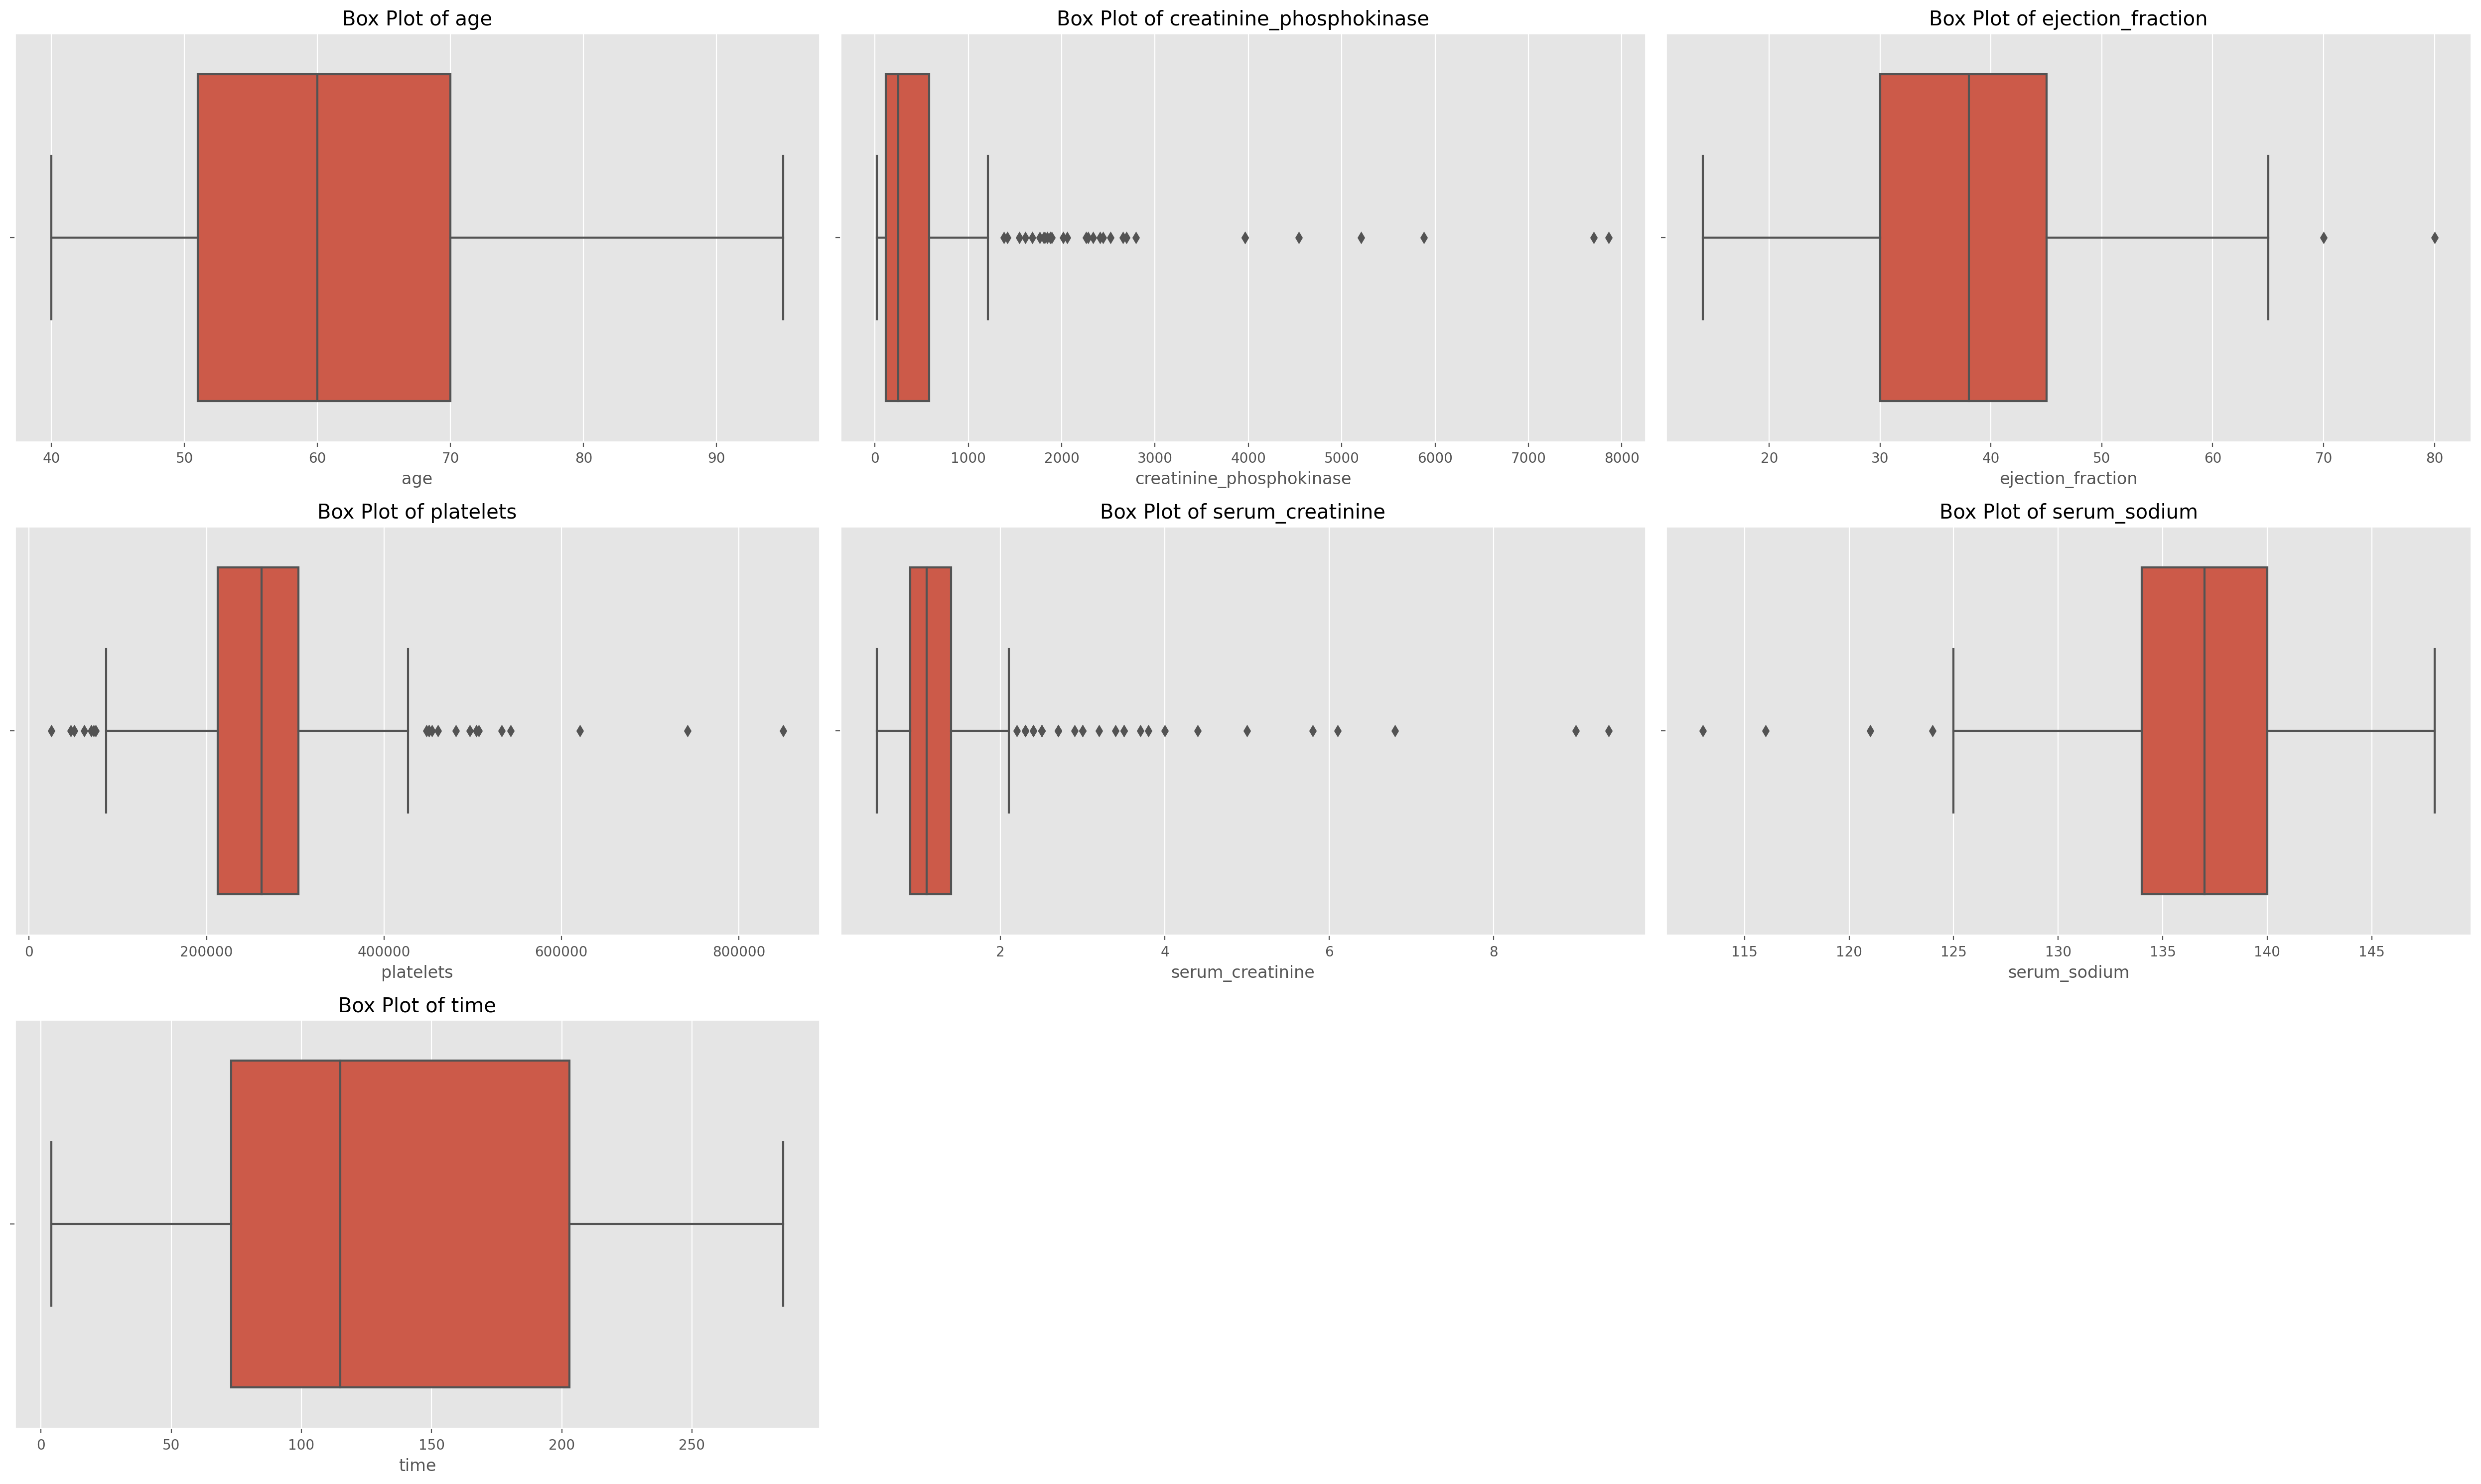

,outliers,percentage
creatinine_phosphokinase,29,9.698997
serum_creatinine,29,9.698997
platelets,21,7.023411
serum_sodium,4,1.337793
ejection_fraction,2,0.668896
age,0,0.000000
time,0,0.000000


In [8]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

Let's remove outliers on every variable using the IQR method.

In [9]:
for i in num_cols:
    q1 = np.quantile(df[i],0.25)
    q3 = np.quantile(df[i],0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)

    df = df[(df[i] >= min_iqr) & (df[i] <= max_iqr)]

Let's check for the second time. As it can be seen, there's only a few outliers left, so we can move on to the next step.

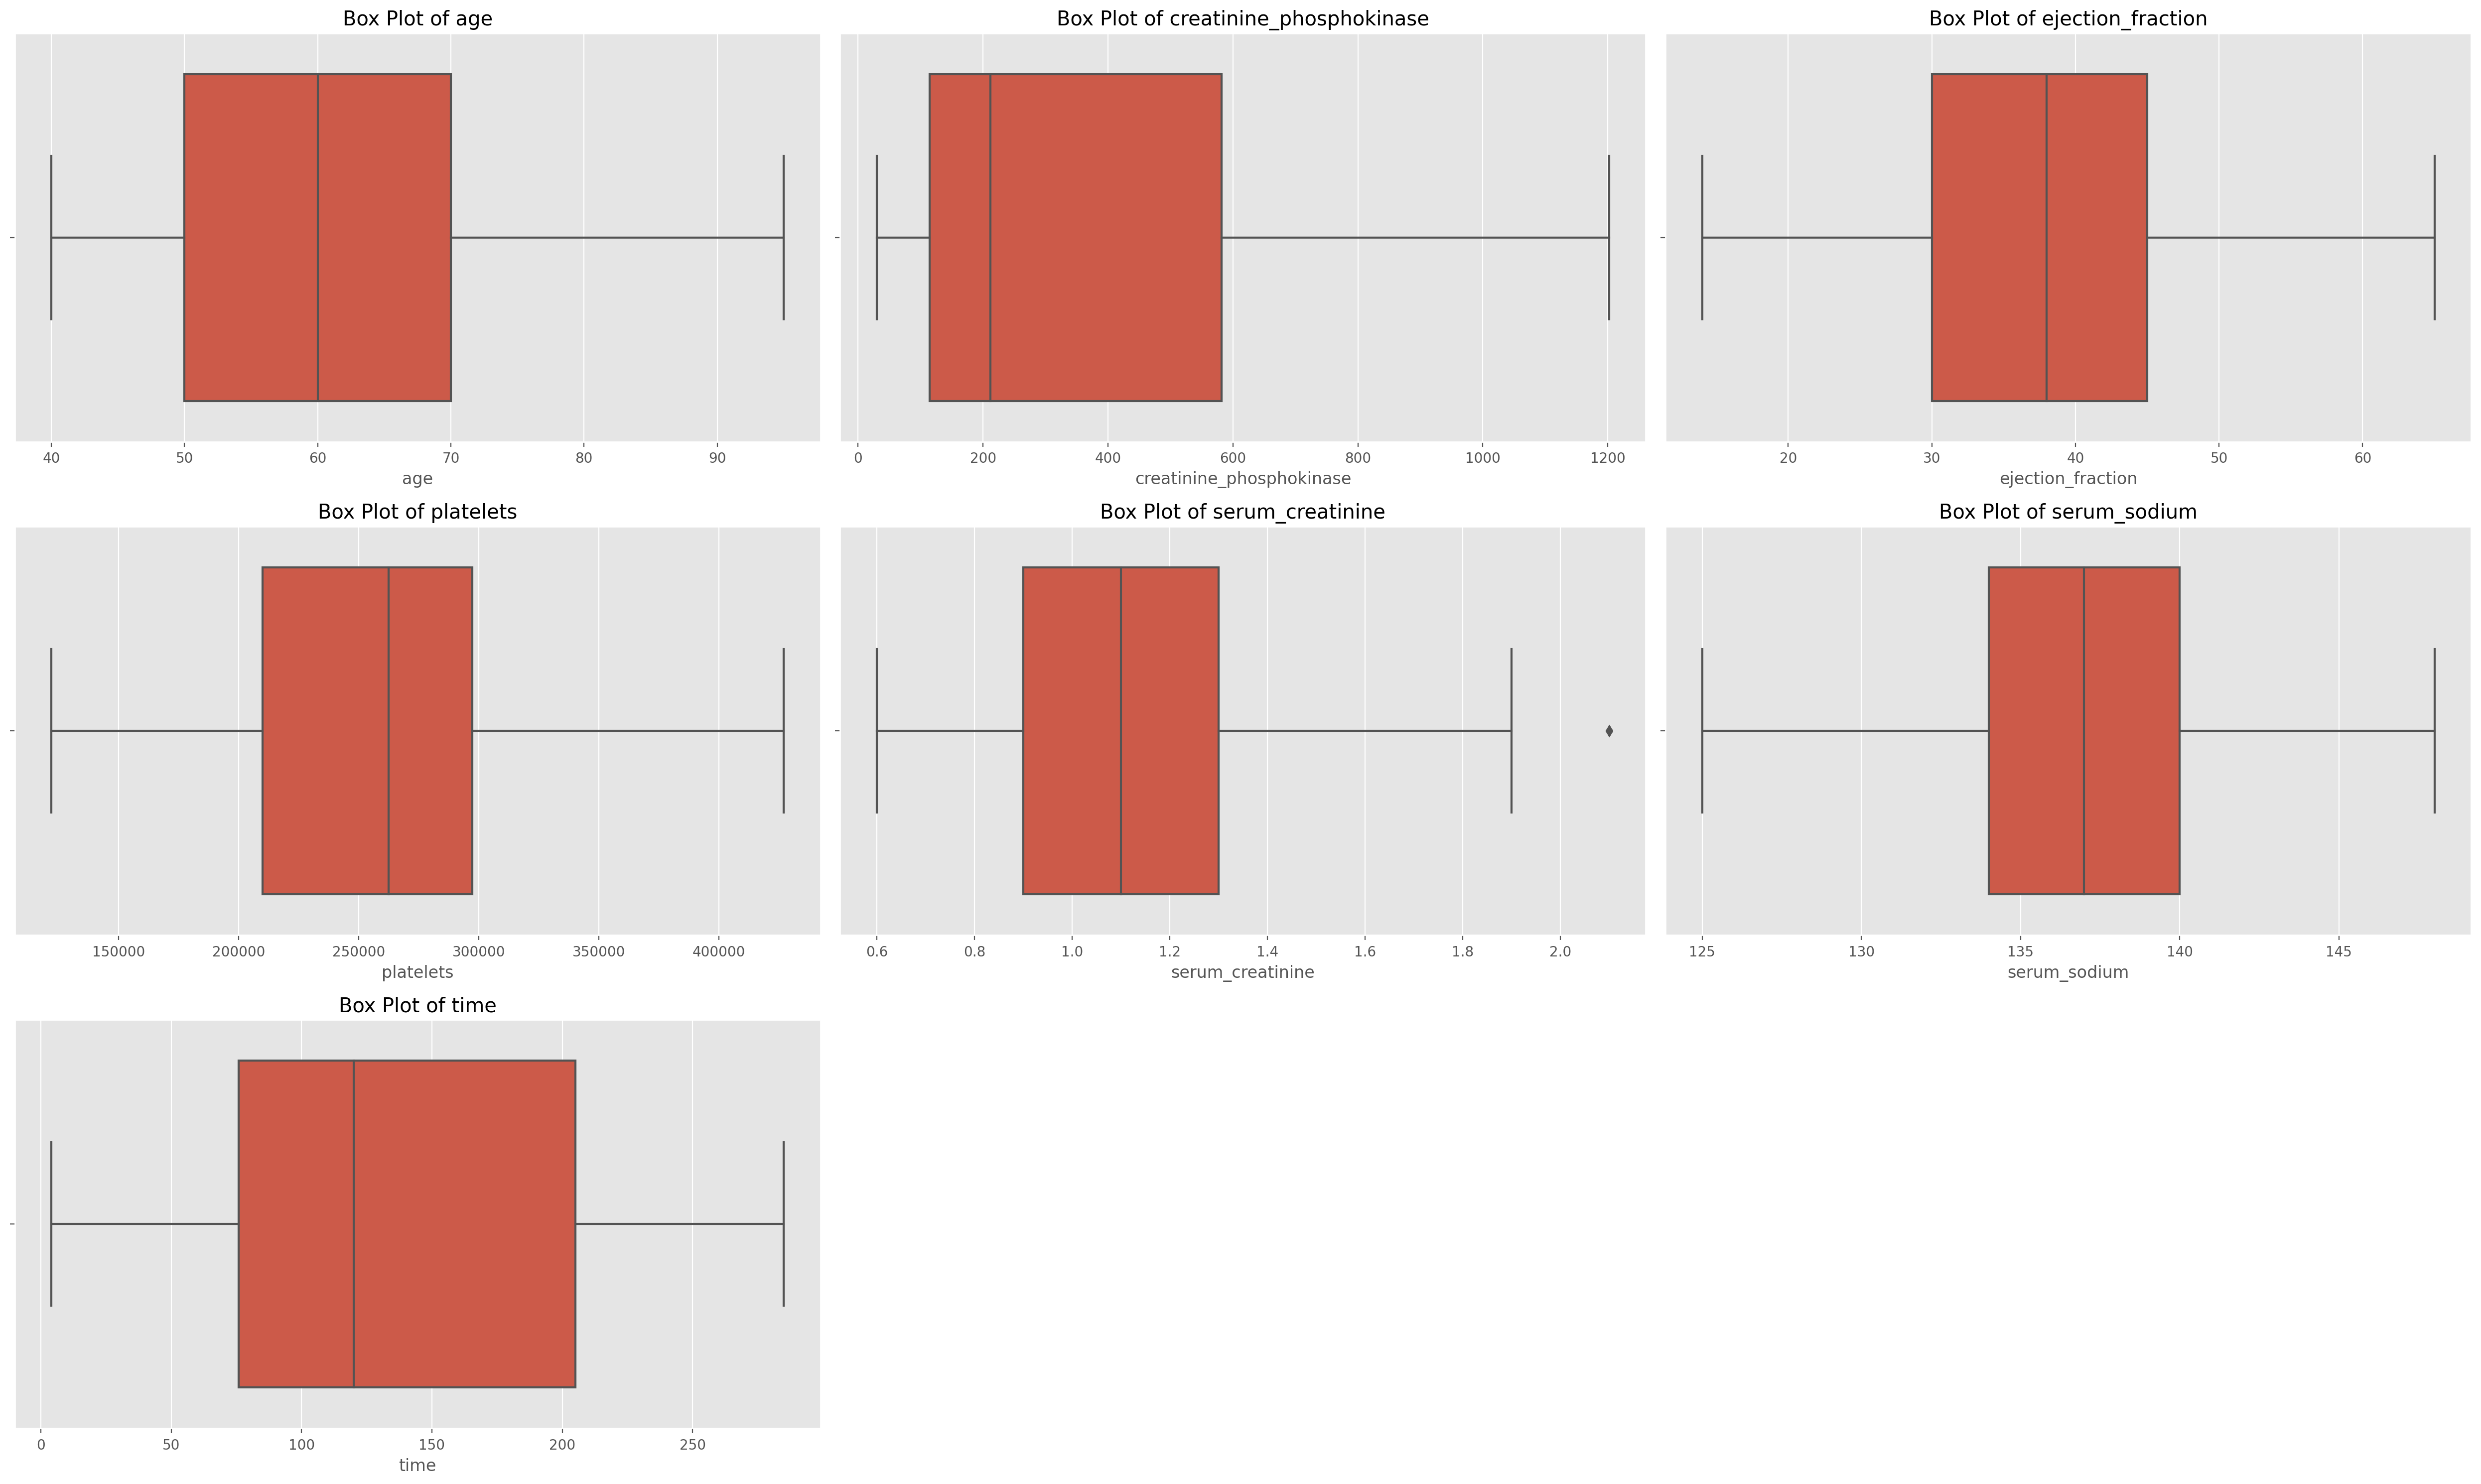

,outliers,percentage
serum_creatinine,3,1.339286
age,0,0.000000
creatinine_phosphokinase,0,0.000000
ejection_fraction,0,0.000000
platelets,0,0.000000
serum_sodium,0,0.000000
time,0,0.000000


In [10]:
create_boxplot(3,3,df,num_cols)
show_outlier(df,num_cols)

# Data Exploration

Find the correlation between features and target, which is *death_event*. As it can be seen, the *time* feature has the most influence on *death_event*.

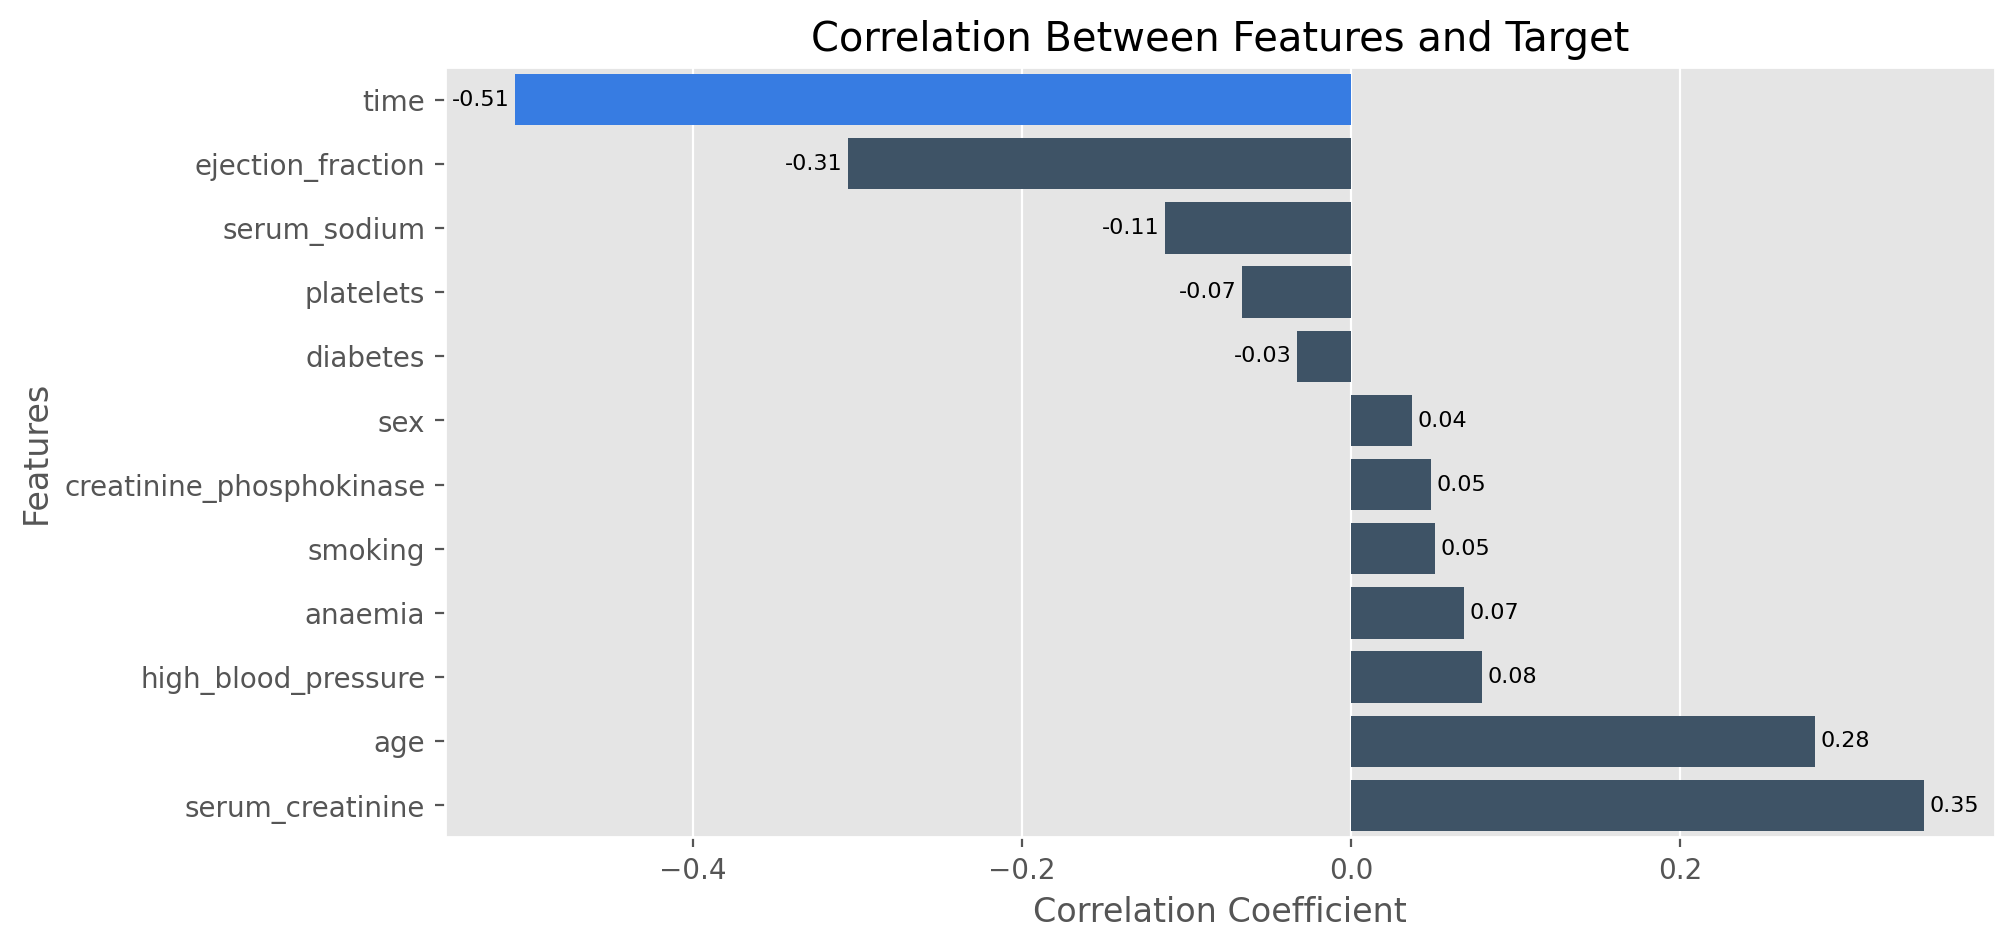

In [11]:
corr = pd.get_dummies(df).iloc[:,:-1].corr()[["death_event_Dead"]].iloc[:-1].sort_values("death_event_Dead")

plt.figure(figsize=(10,5),dpi=200)
ax = sns.barplot(
    data=corr,
    x=corr.death_event_Dead,
    y=corr.index,
    palette=["#1a76ff" if i == np.max(abs(corr.death_event_Dead)) else "#37536d" for i in abs(corr.death_event_Dead)]
)

for container in ax.containers:
    ax.bar_label(container,fmt="%.2f",color="black",fontsize=8,padding=2)

plt.title("Correlation Between Features and Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

The *time* feature has a negative relationship with *death_event*, which means the longer the follow-up period is, the less likely the patient will die.

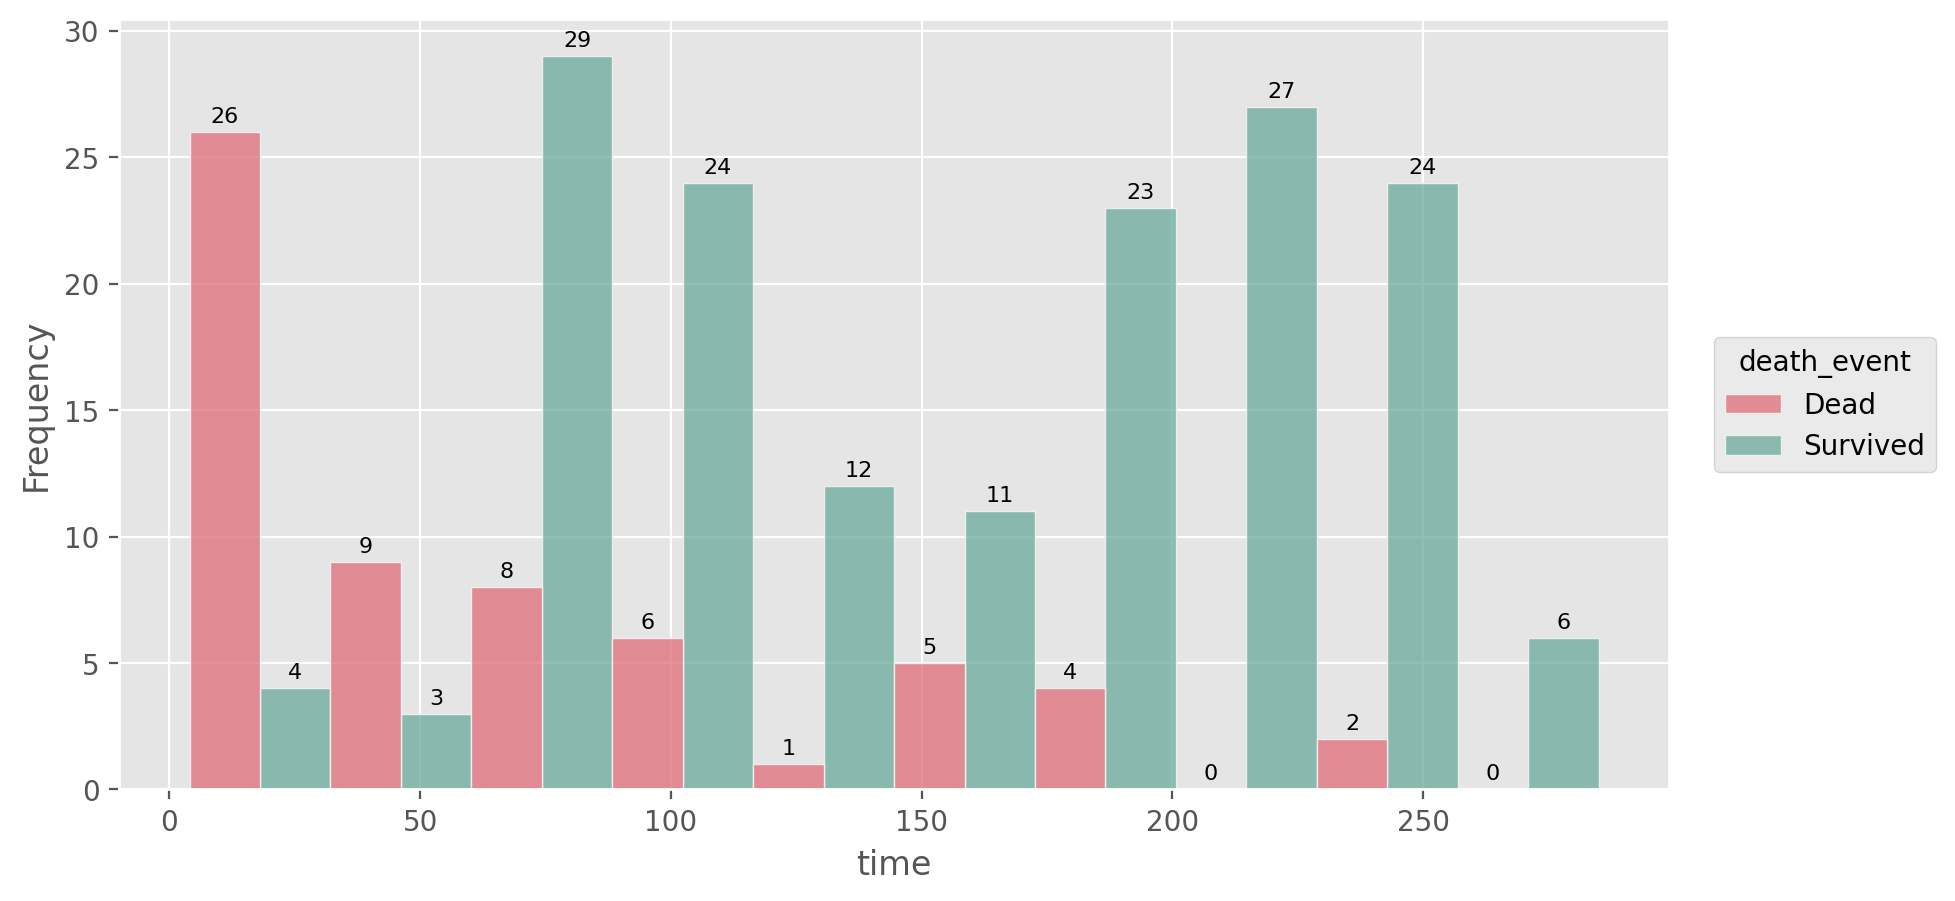

In [12]:
plt.figure(figsize=(10,5),dpi=200)
ax = sns.histplot(df,x="time",hue="death_event",palette=["#E06C78","#6AAB9C"],multiple="dodge",bins=10)

for container in ax.containers:
    ax.bar_label(container,color="black",fontsize=8,padding=2)

sns.move_legend(ax,loc="center left",bbox_to_anchor=(1.02,0.5))
plt.ylabel("Frequency")
plt.show()

Now, let's take a look at the two features that have the most influences after *time*, which are *ejection_fraction* and *serum_creatinine*. The higher the *ejection_fraction* is and the lower the *serum_creatinine* is, the more likely the patient will survive. In order to simplify things, we'll separate *ejection_fraction* and *serum_creatinine* into 2 categories, which are *greater than or equal to* and *less than* the averages.

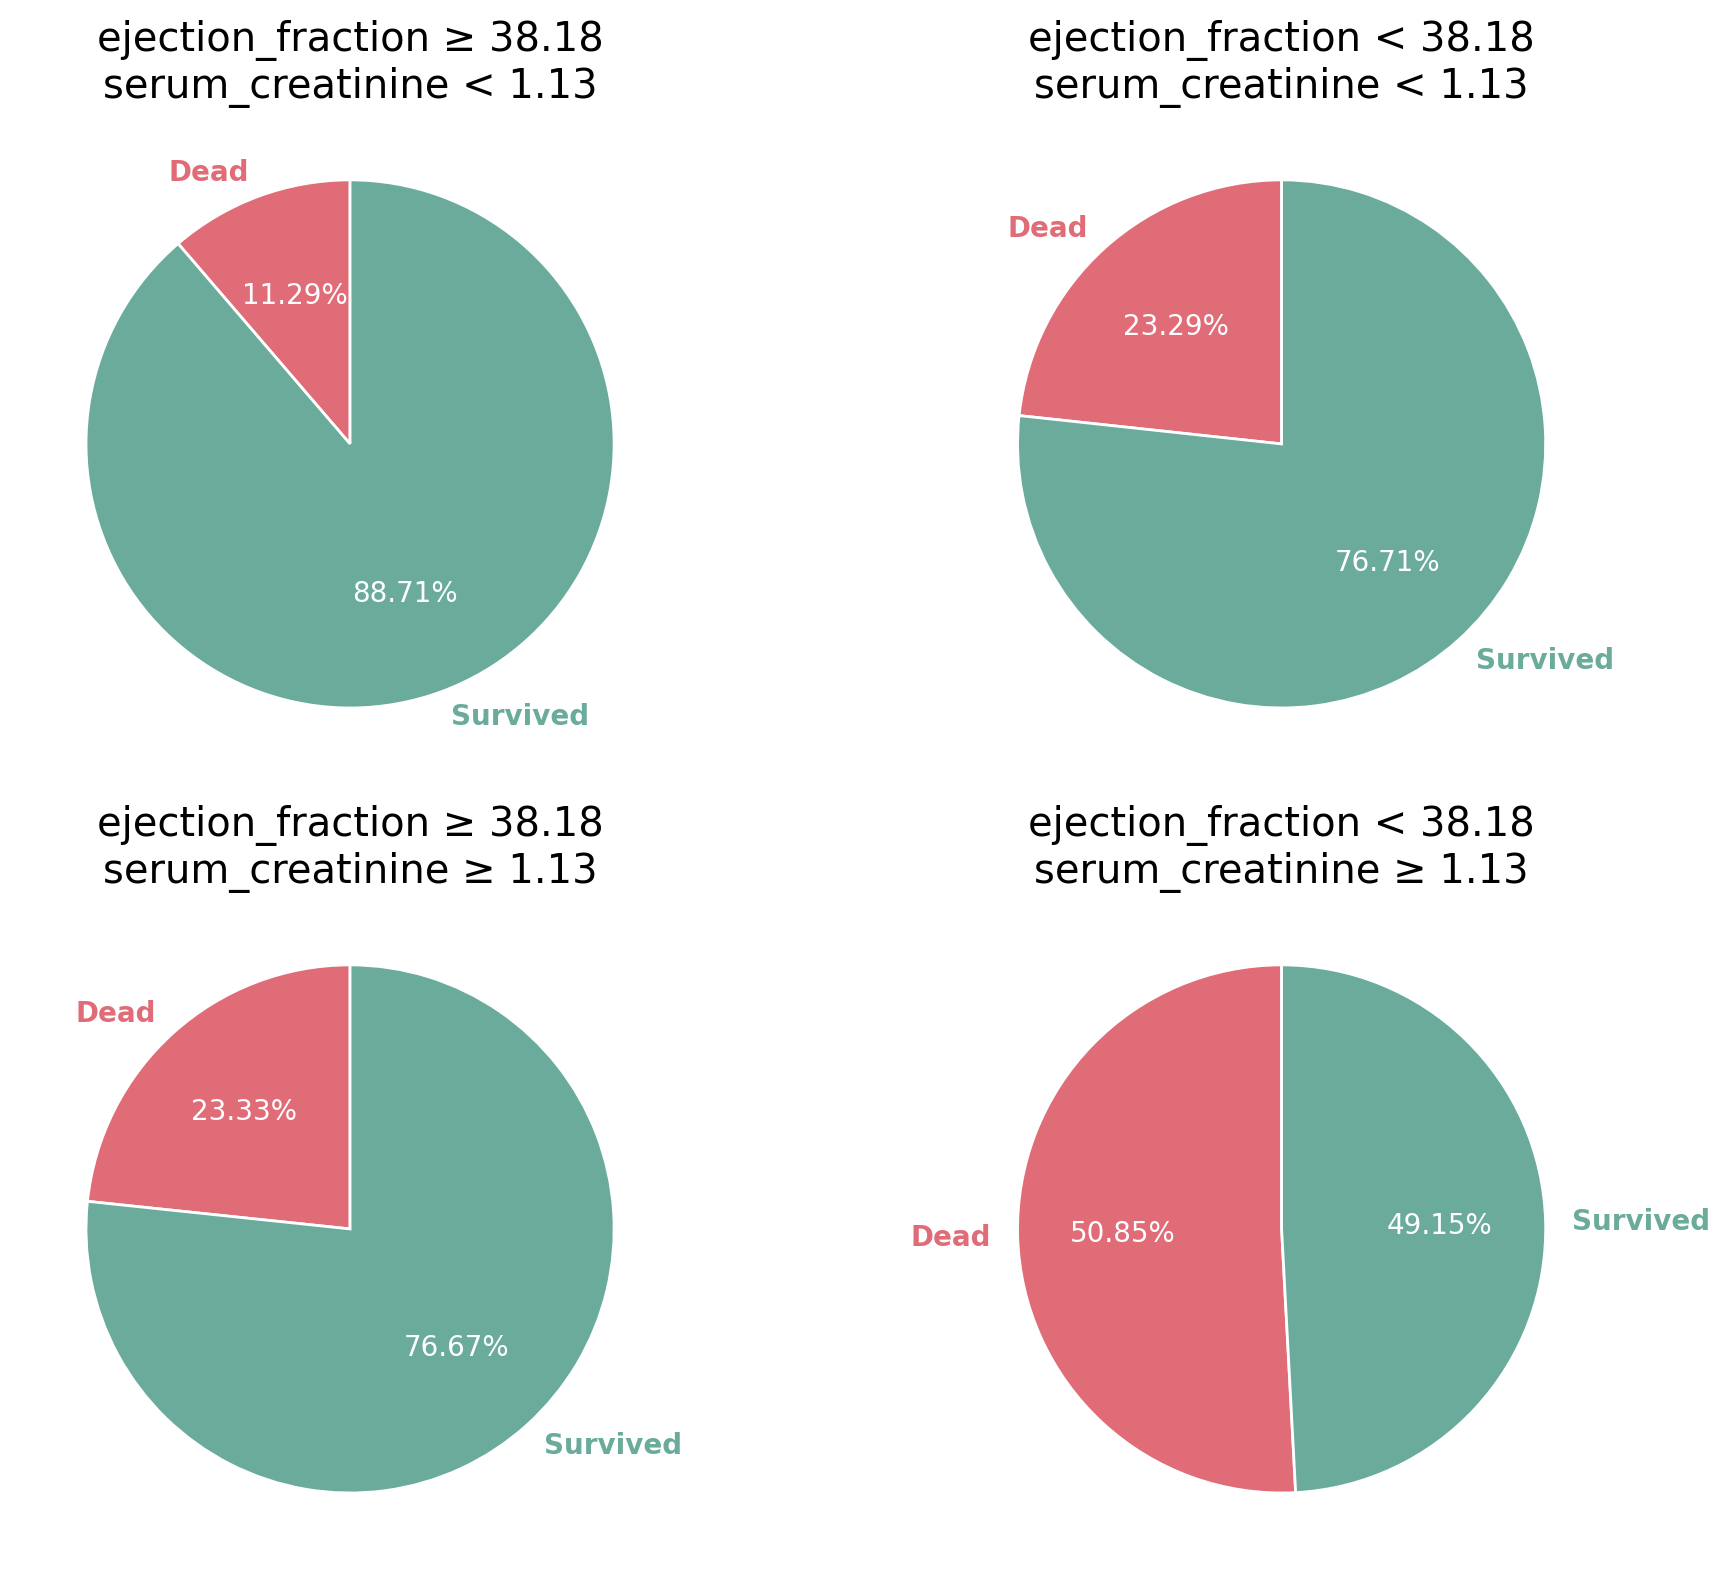

In [13]:
first = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

second = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] < np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

third = df[
    (df["ejection_fraction"] >= np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

fourth = df[
    (df["ejection_fraction"] < np.mean(df["ejection_fraction"])) &
    (df["serum_creatinine"] >= np.mean(df["serum_creatinine"]))
].groupby("death_event").count()[["age"]]

ejection_fraction_and_serum_creatinine = [first,second,third,fourth]
titles = [
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine < {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction ≥ {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
    f"ejection_fraction < {round(np.mean(df['ejection_fraction']),2)}\nserum_creatinine ≥ {round(np.mean(df['serum_creatinine']),2)}",
]

nrows,ncols = 2,2
fig,ax = plt.subplots(nrows,ncols,figsize=(10,8),dpi=200,sharex=True,sharey=True)

n = 0
for nrow in range(nrows):
    for ncol in range(ncols):
        patches,texts,pcts = ax[nrow,ncol].pie(
            ejection_fraction_and_serum_creatinine[n].age,
            labels=ejection_fraction_and_serum_creatinine[n].index,
            startangle=90,
            colors=["#E06C78","#6AAB9C"],
            autopct="%.2f%%",
            wedgeprops={"linewidth":1.0,"edgecolor":"white"}
        )

        ax[nrow,ncol].set_title(titles[n])

        n += 1

        for index,patch in enumerate(patches):
            texts[index].set_color(patch.get_facecolor())

        plt.setp(pcts,color="white")
        plt.setp(texts,fontweight=600)

plt.tight_layout()
plt.show()

According to the American Heart Association, a nonprofit organization in the U.S., a normal *ejection_fraction* is about 50% to 75%. Out of all 224 patients (after removing outliers), only 20.98% of them that have normal *ejection_fraction*(s).

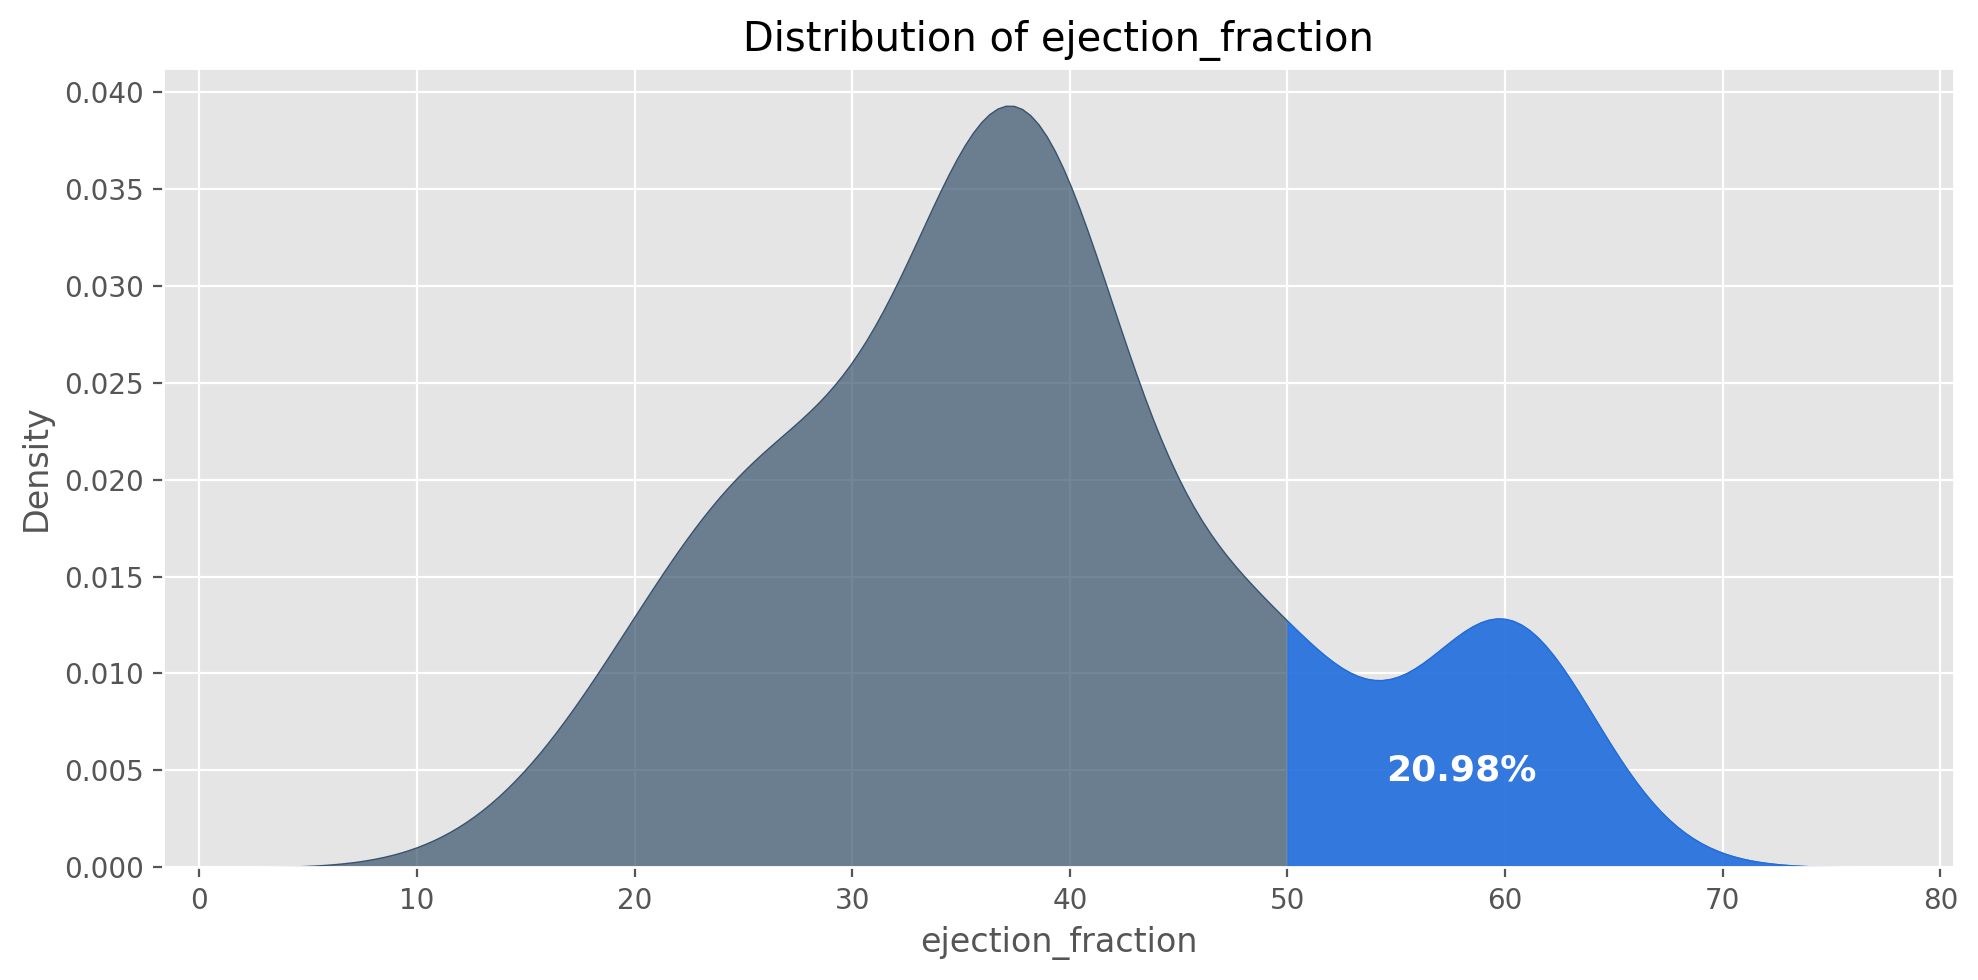

In [14]:
fig,ax = plt.subplots(figsize=(10,5),dpi=200)

kde_ejection_fraction = sns.kdeplot(ax=ax,data=df,x="ejection_fraction",color="#37536d",fill=True,alpha=0.7)
xmin,xmax = kde_ejection_fraction.get_xlim()
kde = gaussian_kde(df["ejection_fraction"])
x = np.linspace(xmin,xmax,10_000)
kde_y = kde(x)

x0,y0 = [],[]
for i,j in zip(x,kde_y):
    if (i >= 50) & (i <= 75):
        x0.append(i)
        y0.append(j)
x0,y0 = np.array(x0),np.array(y0)

area0 = round(simps(y0,x0,dx=1) * 100,0)
kde_ejection_fraction.fill_between(x=x0,y1=y0,color="#1a76ff",alpha=0.7)

ax.set_title("Distribution of ejection_fraction")
ax.set_xlim(xmin,xmax)
ax.text(
    x=58,
    y=0.0045,
    s=f"{round(len(df[(df['ejection_fraction'] >= 50) & (df['ejection_fraction'] <= 75)]) / len(df) * 100,2)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

According to Mayo Clinic, a nonprofit American academic medical center, the typical range for *serum_creatinine* for adult men is 0.74 to 1.35 mg/dL and for adult women is 0.59 to 1.04 mg/dL. Around 68.75% of 144 male patients and 60% of 80 female patients have their *serum_creatinine*(s) within those ranges.

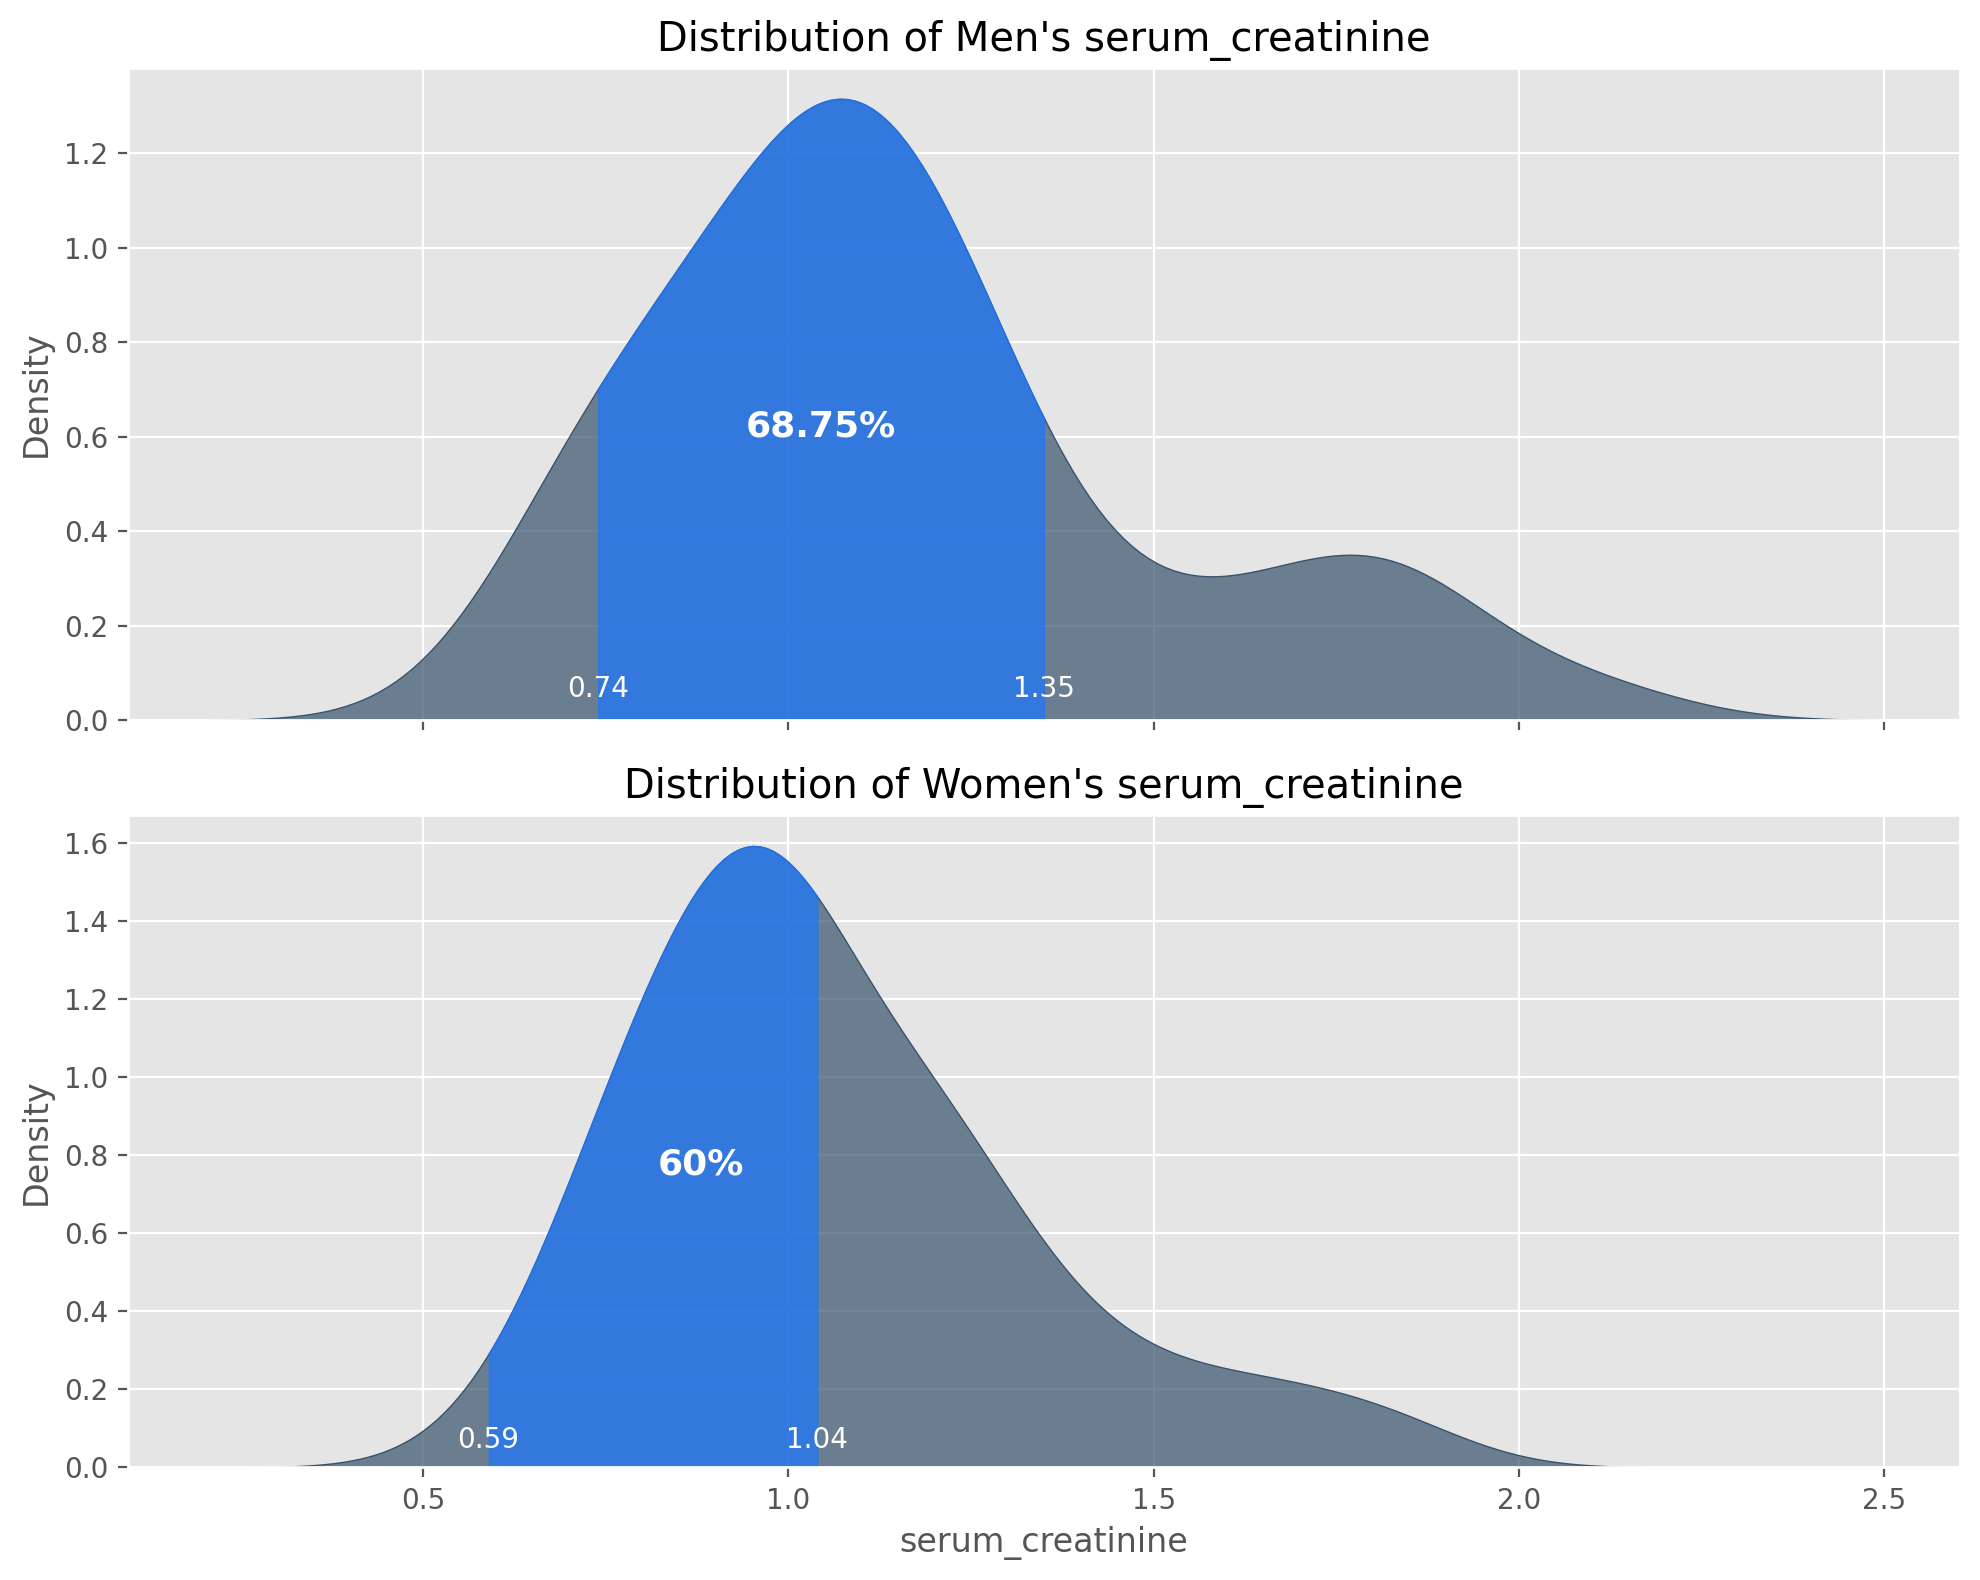

In [15]:
fig,ax = plt.subplots(2,1,figsize=(10,8),dpi=200,sharex=True)

for nrow,lower,upper,sex,title in zip(range(2),[0.74,0.59],[1.35,1.04],[1,0],["Men","Women"]):
    kde_serum_creatinine = sns.kdeplot(ax=ax[nrow],data=df[df["sex"] == sex],x="serum_creatinine",color="#37536d",fill=True,alpha=0.7)
    xmin,xmax = kde_serum_creatinine.get_xlim()
    kde = gaussian_kde(df[df["sex"] == sex]["serum_creatinine"])
    x = np.linspace(xmin,xmax,10_000)
    kde_y = kde(x)

    x0,y0 = [],[]
    for i,j in zip(x,kde_y):
        if (i >= lower) & (i <= upper):
            x0.append(i)
            y0.append(j)
    x0,y0 = np.array(x0),np.array(y0)

    area0 = round(simps(y0,x0,dx=1) * 100,0)
    kde_serum_creatinine.fill_between(x=x0,y1=y0,color="#1a76ff",alpha=0.7)

    ax[nrow].set_title(f"Distribution of {title}'s serum_creatinine")

    for tick in [lower,upper]:
        ax[nrow].text(x=tick,y=0.05,s=tick,horizontalalignment="center",color="white",fontweight=500)

ax[0].text(
    x=0.74 + ((1.35 - 0.74) / 2),
    y=0.6,
    s=f"{len(df[(df['sex'] == 1) & (df['serum_creatinine'] >= 0.74) & (df['serum_creatinine'] <= 1.35)]) / len(df[df['sex'] == 1]) * 100}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

ax[1].text(
    x=0.88,
    y=0.75,
    s=f"{int(len(df[(df['sex'] == 0) & (df['serum_creatinine'] >= 0.59) & (df['serum_creatinine'] <= 1.04)]) / len(df[df['sex'] == 0]) * 100)}%",
    horizontalalignment="center",
    color="white",
    fontweight="bold",
    fontsize=13
)

plt.tight_layout()
plt.show()

# Data Preprocessing

Define features as *X* and target as *y*.

In [16]:
X = df.drop("death_event",axis=1)
y = df["death_event"]

Split the dataset into 80% training data and 20% testing data. *random_state* ensures that we have the same train-test split every time. The seed number for *random_state* doesn't have to be 62 as it can be any number.

In [17]:
random_state = 62
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 179	(80%)
Testing dataset		: 45	(20%)


Since we have an imbalanced dataset, we can handle that problem by oversampling the minority class or undersampling the majority class. Many researchers also suggest combining oversampling and undersampling methods to balance the dataset better. We'll compare the following methods with the baseline Random Forest and Gradient Boosting models results:
- Random Oversampling
- SMOTE Oversampling
- Random Undersampling
- NearMiss Undersampling
- SMOTE + Tomek Links
- SMOTE + Edited Nearest Neighbor

It's important to note that we apply the resampling methods to the training dataset only while the testing dataset needs to keep untouched.

In [18]:
# Random Oversampling
ros = RandomOverSampler(random_state=random_state)
X_train_ros,y_train_ros = ros.fit_resample(X_train,y_train)

# SMOTE Oversampling
smote = SMOTE(random_state=random_state)
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)

# Random Undersampling
rus = RandomUnderSampler(random_state=random_state)
X_train_rus,y_train_rus = rus.fit_resample(X_train,y_train)

# NearMiss Undersampling
nearmiss = NearMiss(version=3)
X_train_nearmiss,y_train_nearmiss = nearmiss.fit_resample(X_train,y_train)

# SMOTE + Tomek Links
smotetomek = SMOTETomek(random_state=random_state)
X_train_smotetomek,y_train_smotetomek = smotetomek.fit_resample(X_train,y_train)

# SMOTE + Edited Nearest Neighbors
smoteenn = SMOTEENN(random_state=random_state)
X_train_smoteenn,y_train_smoteenn = smoteenn.fit_resample(X_train,y_train)

Let's take two random numerical features to visualize our dataset using a scatter plot. We can see that majority of the dataset belongs to class *Survived* and a small portion of the dataset belongs to class *Dead*.

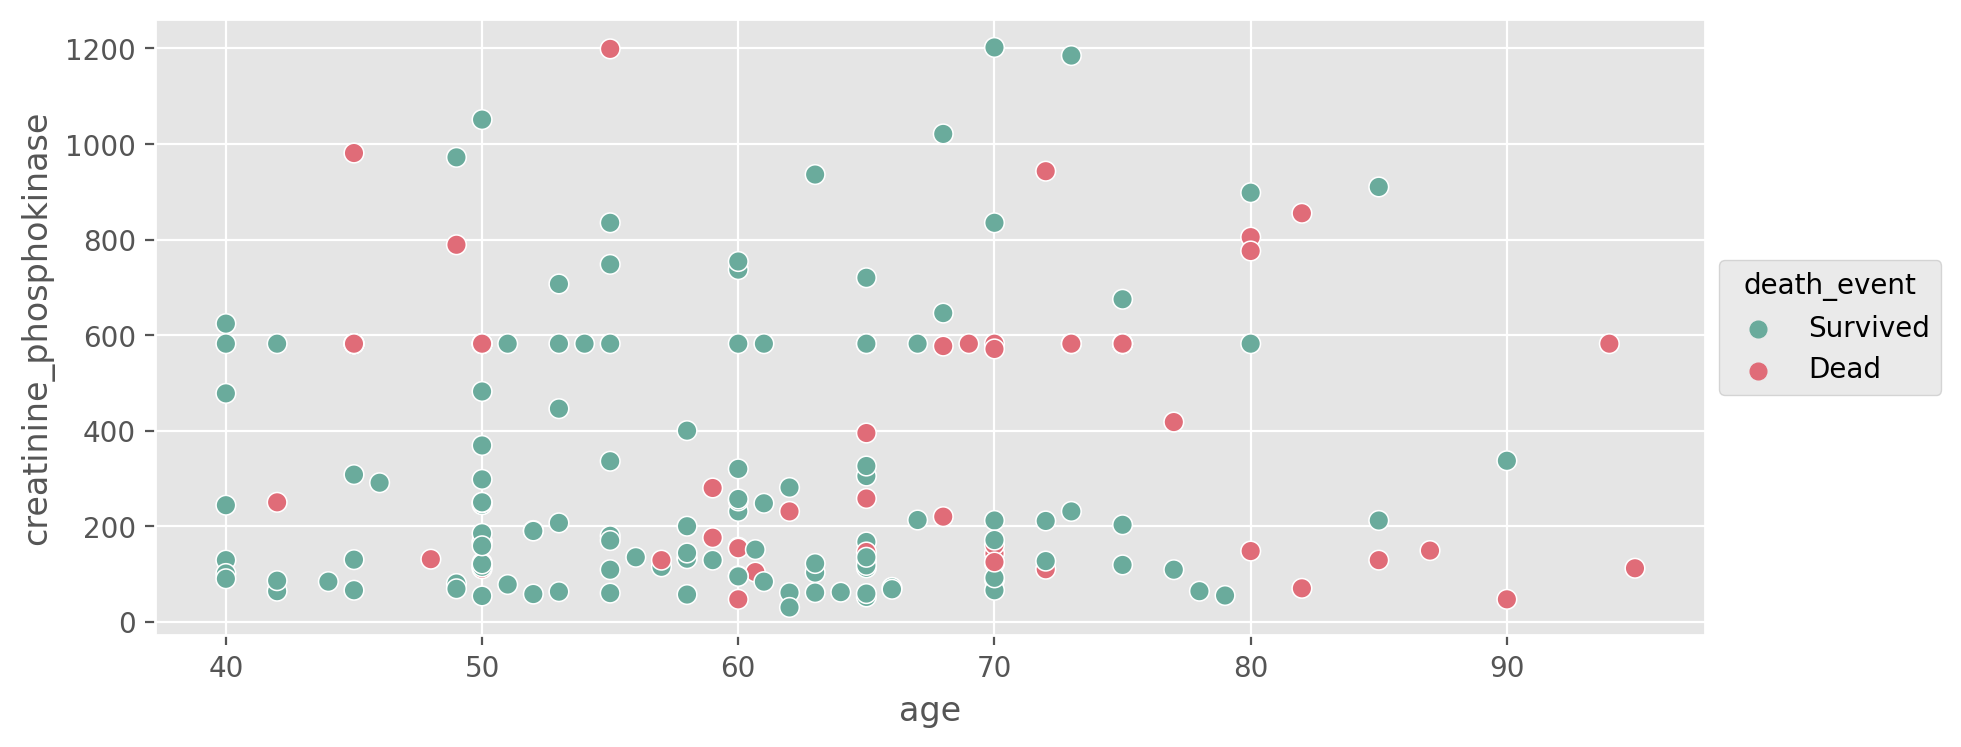

In [19]:
plt.figure(figsize=(10,4),dpi=200)
ax = sns.scatterplot(
    data=pd.concat([X_train,y_train],axis=1),
    x="age",
    y="creatinine_phosphokinase",
    hue="death_event",
    palette=["#6AAB9C","#E06C78"],
    s=50
)
plt.legend(bbox_to_anchor=(1,0.5),loc="center left",title="death_event")

plt.show()

After applying the resampling methods to the dataset, we can see that the dataset is more balanced.

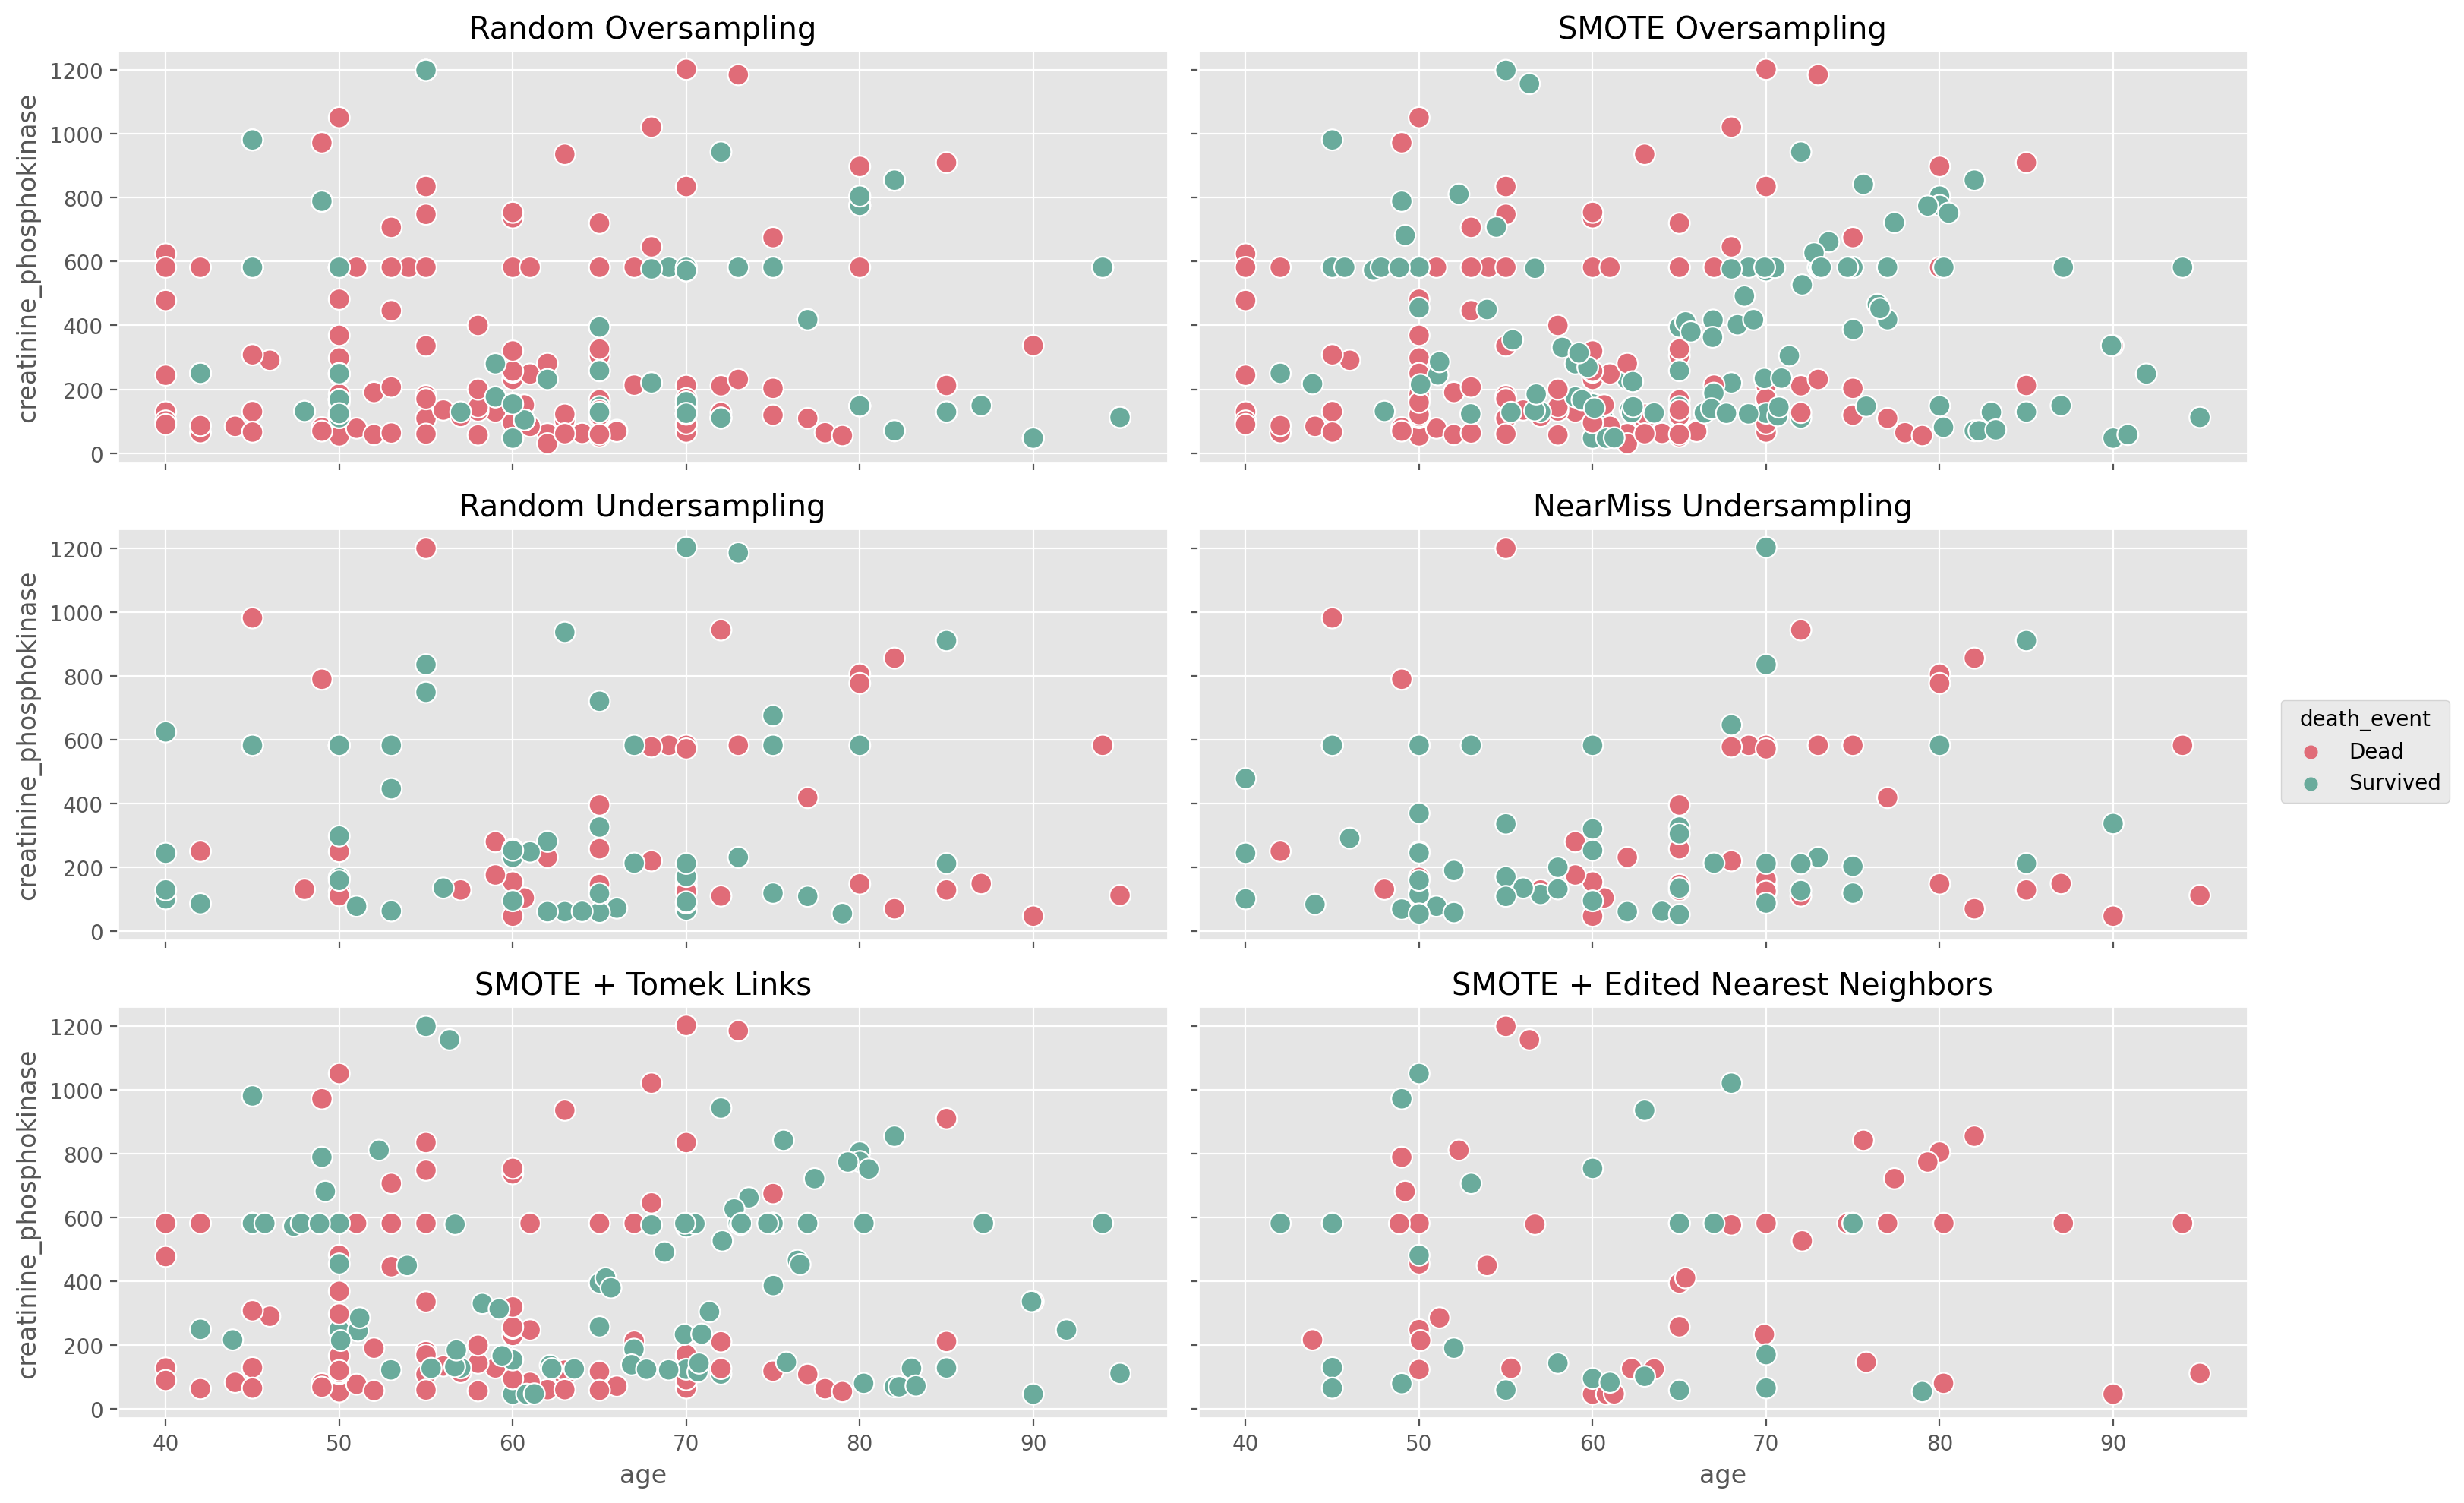

In [20]:
X_trains = [X_train_ros,X_train_smote,X_train_rus,X_train_nearmiss,X_train_smotetomek,X_train_smoteenn]
y_trains = [y_train_ros,y_train_smote,y_train_rus,y_train_nearmiss,y_train_smotetomek,y_train_smoteenn]
titles = [
    "Random Oversampling","SMOTE Oversampling","Random Undersampling",
    "NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

nrows,ncols = 3,2
fig,ax = plt.subplots(nrows,ncols,figsize=(15,10),dpi=200,sharex=True,sharey=True)

n = 0
for nrow in range(nrows):
    for ncol in range(ncols):
        sns.scatterplot(
            data=pd.concat([X_trains[n],y_trains[n]],axis=1),
            x="age",
            y="creatinine_phosphokinase",
            hue="death_event",
            palette=["#E06C78","#6AAB9C"],
            s=100,
            ax=ax[nrow,ncol]
        )
        ax[nrow,ncol].set_title(titles[n])
        ax[nrow,ncol].legend([],[],frameon=False)
        n += 1

handles,labels = ax[nrow,ncol].get_legend_handles_labels()
fig.legend(handles,labels,bbox_to_anchor=(1,0.5),loc="center left",title="death_event")

plt.tight_layout()
plt.show()

Due to our features have different scales, we can standardize them.

In [21]:
scaler = StandardScaler()

# Base
scaled_X_train = scaler.fit_transform(X_train)

# Random Oversampling
scaled_X_train_ros = scaler.fit_transform(X_train_ros)

# SMOTE Oversampling
scaled_X_train_smote = scaler.fit_transform(X_train_smote)

# Random Undersampling
scaled_X_train_rus = scaler.fit_transform(X_train_rus)

# NearMiss Undersampling
scaled_X_train_nearmiss = scaler.fit_transform(X_train_nearmiss)

# SMOTE + Tomek Links
scaled_X_train_smotetomek = scaler.fit_transform(X_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
scaled_X_train_smoteenn = scaler.fit_transform(X_train_smoteenn)

scaled_X_test = scaler.transform(X_test)

# Models Definition & Training

To begin with, we create models without resampling methods as baselines to compare the models performance. Random Forest and Gradient Boosting models are used for this dataset. Note that there are two baseline Random Forest models (with and without the *class_weight* parameter) while there's only one baseline Gradient Boosting model since it doesn't have the *class_weight* parameter. Next, we're going to create other Random Forest and Gradient Boosting models with different resampling methods.

In [22]:
# Base
rf_model_base = RandomForestClassifier(random_state=random_state)
rf_model_base.fit(scaled_X_train,y_train)

# Base (class_weight = "balanced")
rf_model_base_balanced = RandomForestClassifier(random_state=random_state,class_weight="balanced")
rf_model_base_balanced.fit(scaled_X_train,y_train)

# Random Oversampling
rf_model_ros = RandomForestClassifier(random_state=random_state)
rf_model_ros.fit(scaled_X_train_ros,y_train_ros)

# SMOTE Oversampling
rf_model_smote = RandomForestClassifier(random_state=random_state)
rf_model_smote.fit(scaled_X_train_smote,y_train_smote)

# Random Undersampling
rf_model_rus = RandomForestClassifier(random_state=random_state)
rf_model_rus.fit(scaled_X_train_rus,y_train_rus)

# NearMiss Undersampling
rf_model_nearmiss = RandomForestClassifier(random_state=random_state)
rf_model_nearmiss.fit(scaled_X_train_nearmiss,y_train_nearmiss)

# SMOTE + Tomek Links
rf_model_smotetomek = RandomForestClassifier(random_state=random_state)
rf_model_smotetomek.fit(scaled_X_train_smotetomek,y_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
rf_model_smoteenn = RandomForestClassifier(random_state=random_state)
rf_model_smoteenn.fit(scaled_X_train_smoteenn,y_train_smoteenn)

RandomForestClassifier(random_state=62)

In [23]:
# Base
gb_model_base = GradientBoostingClassifier(random_state=random_state)
gb_model_base.fit(scaled_X_train,y_train)

# Random Oversampling
gb_model_ros = GradientBoostingClassifier(random_state=random_state)
gb_model_ros.fit(scaled_X_train_ros,y_train_ros)

# SMOTE Oversampling
gb_model_smote = GradientBoostingClassifier(random_state=random_state)
gb_model_smote.fit(scaled_X_train_smote,y_train_smote)

# Random Undersampling
gb_model_rus = GradientBoostingClassifier(random_state=random_state)
gb_model_rus.fit(scaled_X_train_rus,y_train_rus)

# NearMiss Undersampling
gb_model_nearmiss = GradientBoostingClassifier(random_state=random_state)
gb_model_nearmiss.fit(scaled_X_train_nearmiss,y_train_nearmiss)

# SMOTE + Tomek Links
gb_model_smotetomek = GradientBoostingClassifier(random_state=random_state)
gb_model_smotetomek.fit(scaled_X_train_smotetomek,y_train_smotetomek)

# SMOTE + Edited Nearest Neighbors
gb_model_smoteenn = GradientBoostingClassifier(random_state=random_state)
gb_model_smoteenn.fit(scaled_X_train_smoteenn,y_train_smoteenn)

GradientBoostingClassifier(random_state=62)

# Models Prediction

Once we created our models, we'll predict the testing dataset and store the results.

In [24]:
# Base
rf_pred_base = rf_model_base.predict(scaled_X_test)
rf_proba_base = rf_model_base.predict_proba(scaled_X_test)

# Base (class_weight = "balanced")
rf_pred_base_balanced = rf_model_base_balanced.predict(scaled_X_test)
rf_proba_base_balanced = rf_model_base_balanced.predict_proba(scaled_X_test)

# Random Oversampling
rf_pred_ros = rf_model_ros.predict(scaled_X_test)
rf_proba_ros = rf_model_ros.predict_proba(scaled_X_test)

# SMOTE Oversampling
rf_pred_smote = rf_model_smote.predict(scaled_X_test)
rf_proba_smote = rf_model_smote.predict_proba(scaled_X_test)

# Random Undersampling
rf_pred_rus = rf_model_rus.predict(scaled_X_test)
rf_proba_rus = rf_model_rus.predict_proba(scaled_X_test)

# NearMiss Undersampling
rf_pred_nearmiss = rf_model_nearmiss.predict(scaled_X_test)
rf_proba_nearmiss = rf_model_nearmiss.predict_proba(scaled_X_test)

# SMOTE + Tomek Links
rf_pred_smotetomek = rf_model_smotetomek.predict(scaled_X_test)
rf_proba_smotetomek = rf_model_smotetomek.predict_proba(scaled_X_test)

# SMOTE + Edited Nearest Neighbors
rf_pred_smoteenn = rf_model_smoteenn.predict(scaled_X_test)
rf_proba_smoteenn = rf_model_smoteenn.predict_proba(scaled_X_test)

In [25]:
# Base
gb_pred_base = gb_model_base.predict(scaled_X_test)
gb_proba_base = gb_model_base.predict_proba(scaled_X_test)

# Random Oversampling
gb_pred_ros = gb_model_ros.predict(scaled_X_test)
gb_proba_ros = gb_model_ros.predict_proba(scaled_X_test)

# SMOTE Oversampling
gb_pred_smote = gb_model_smote.predict(scaled_X_test)
gb_proba_smote = gb_model_smote.predict_proba(scaled_X_test)

# Random Undersampling
gb_pred_rus = gb_model_rus.predict(scaled_X_test)
gb_proba_rus = gb_model_rus.predict_proba(scaled_X_test)

# NearMiss Undersampling
gb_pred_nearmiss = gb_model_nearmiss.predict(scaled_X_test)
gb_proba_nearmiss = gb_model_nearmiss.predict_proba(scaled_X_test)

# SMOTE + Tomek Links
gb_pred_smotetomek = gb_model_smotetomek.predict(scaled_X_test)
gb_proba_smotetomek = gb_model_smotetomek.predict_proba(scaled_X_test)

# SMOTE + Edited Nearest Neighbors
gb_pred_smoteenn = gb_model_smoteenn.predict(scaled_X_test)
gb_proba_smoteenn = gb_model_smoteenn.predict_proba(scaled_X_test)

# Models Evaluation

To begin with, let's do a simple evaluation by creating a confusion matrix plot for every model.

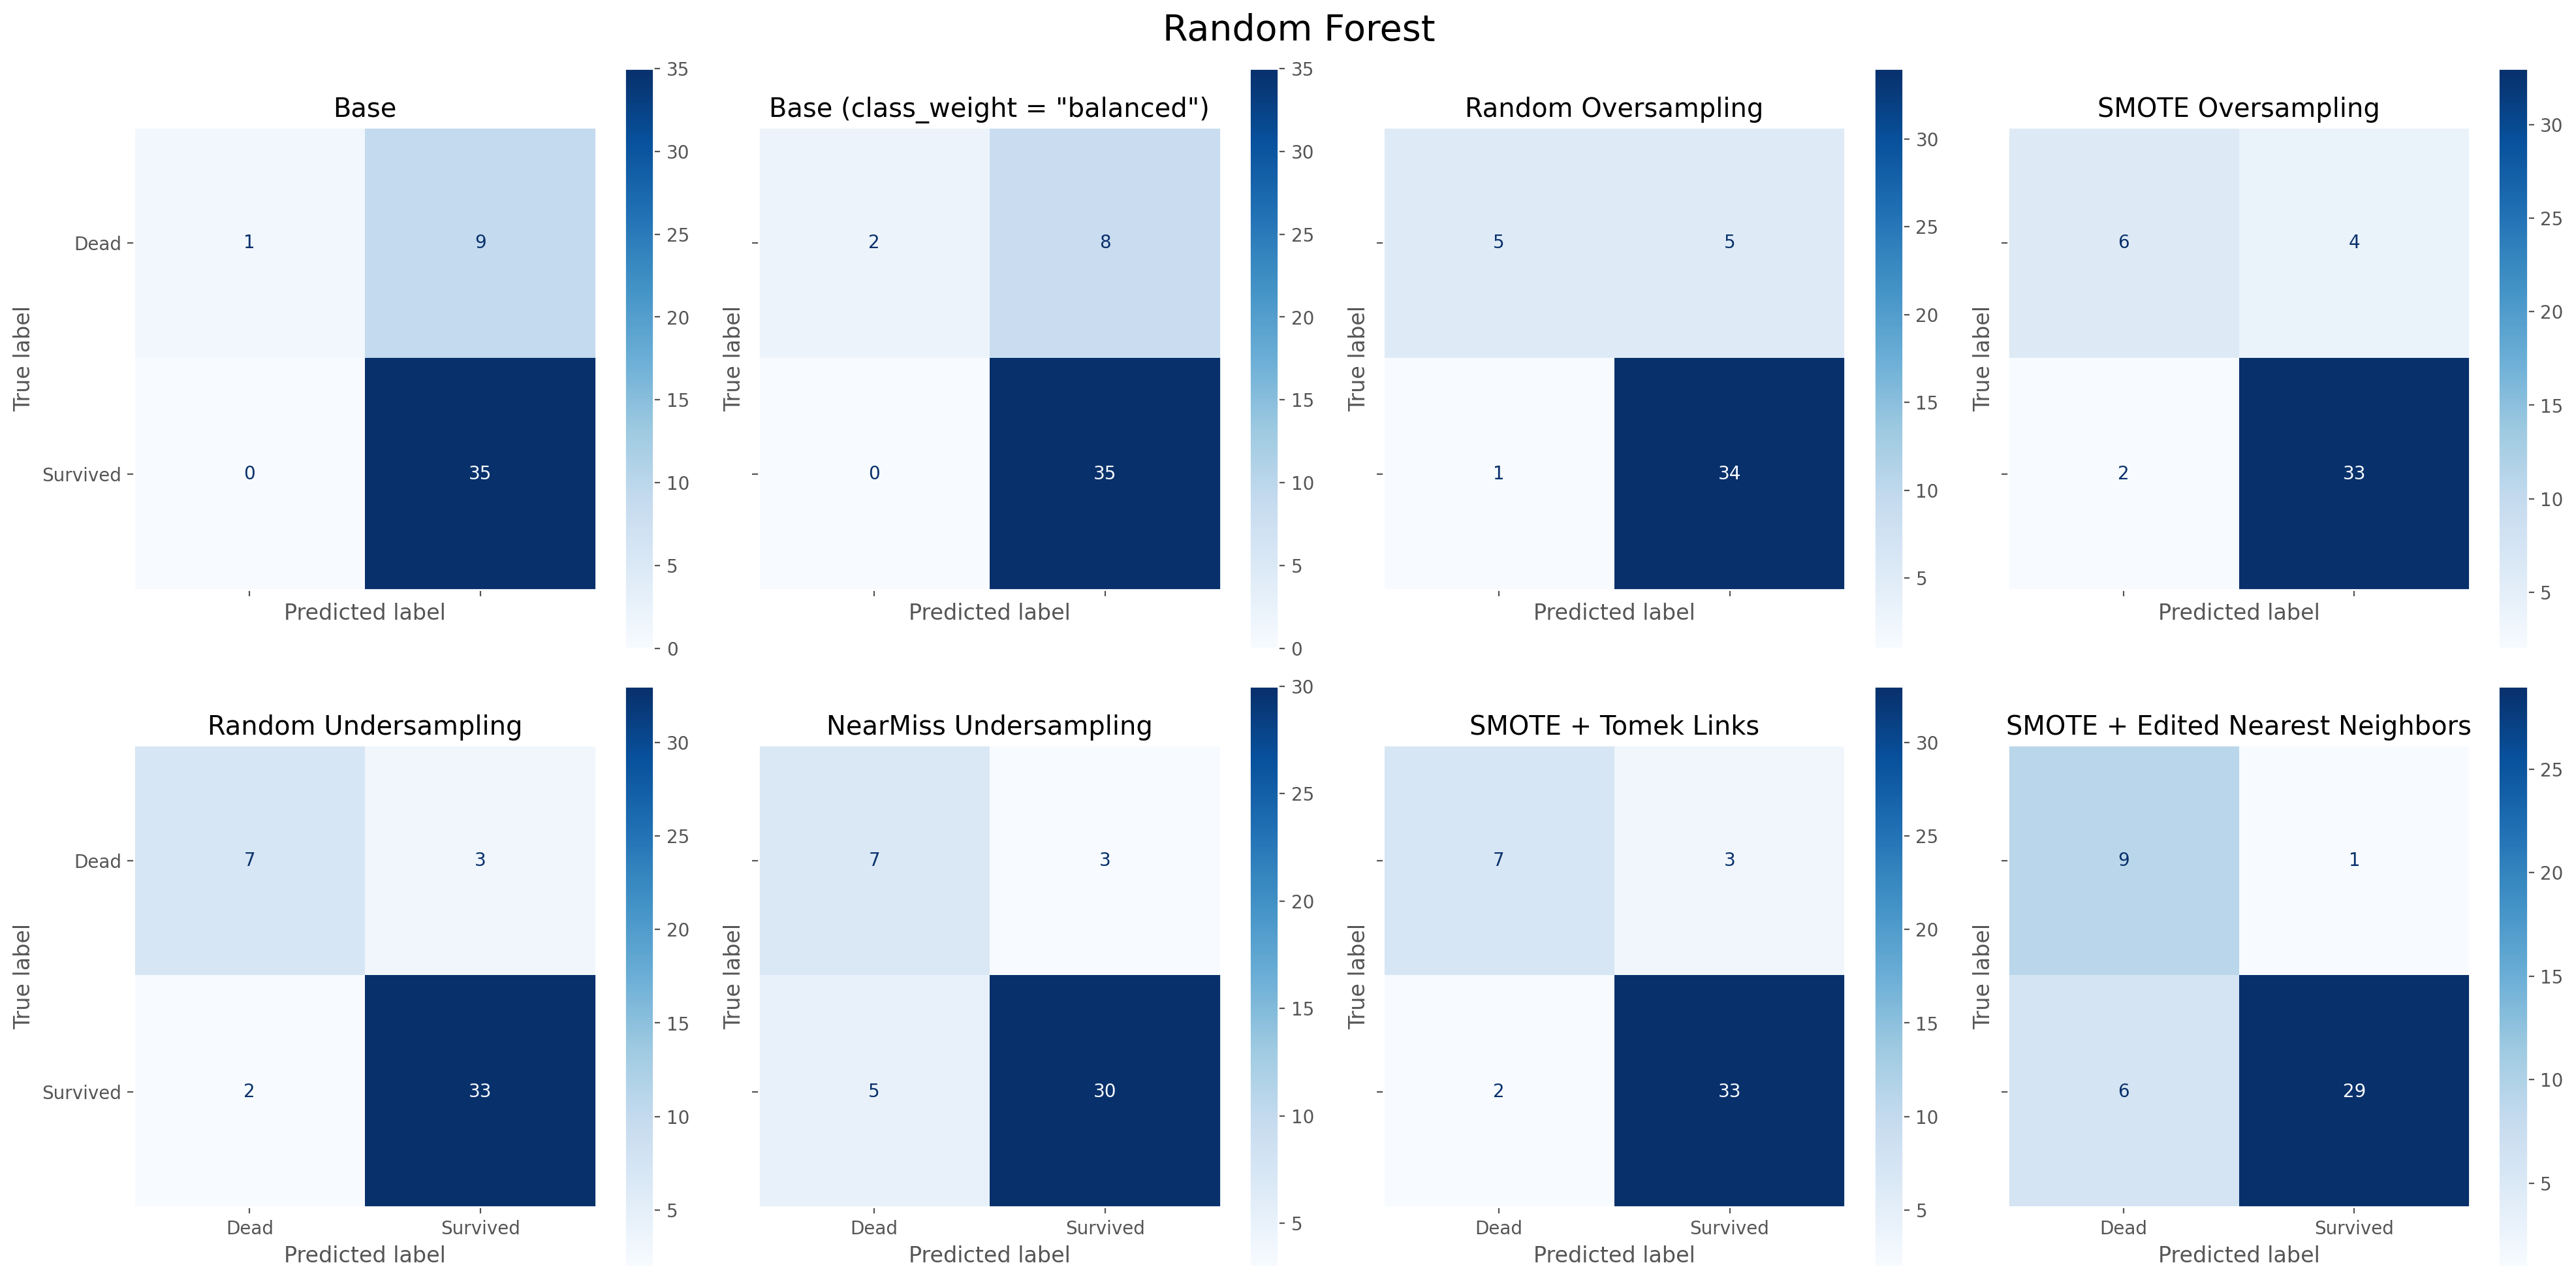

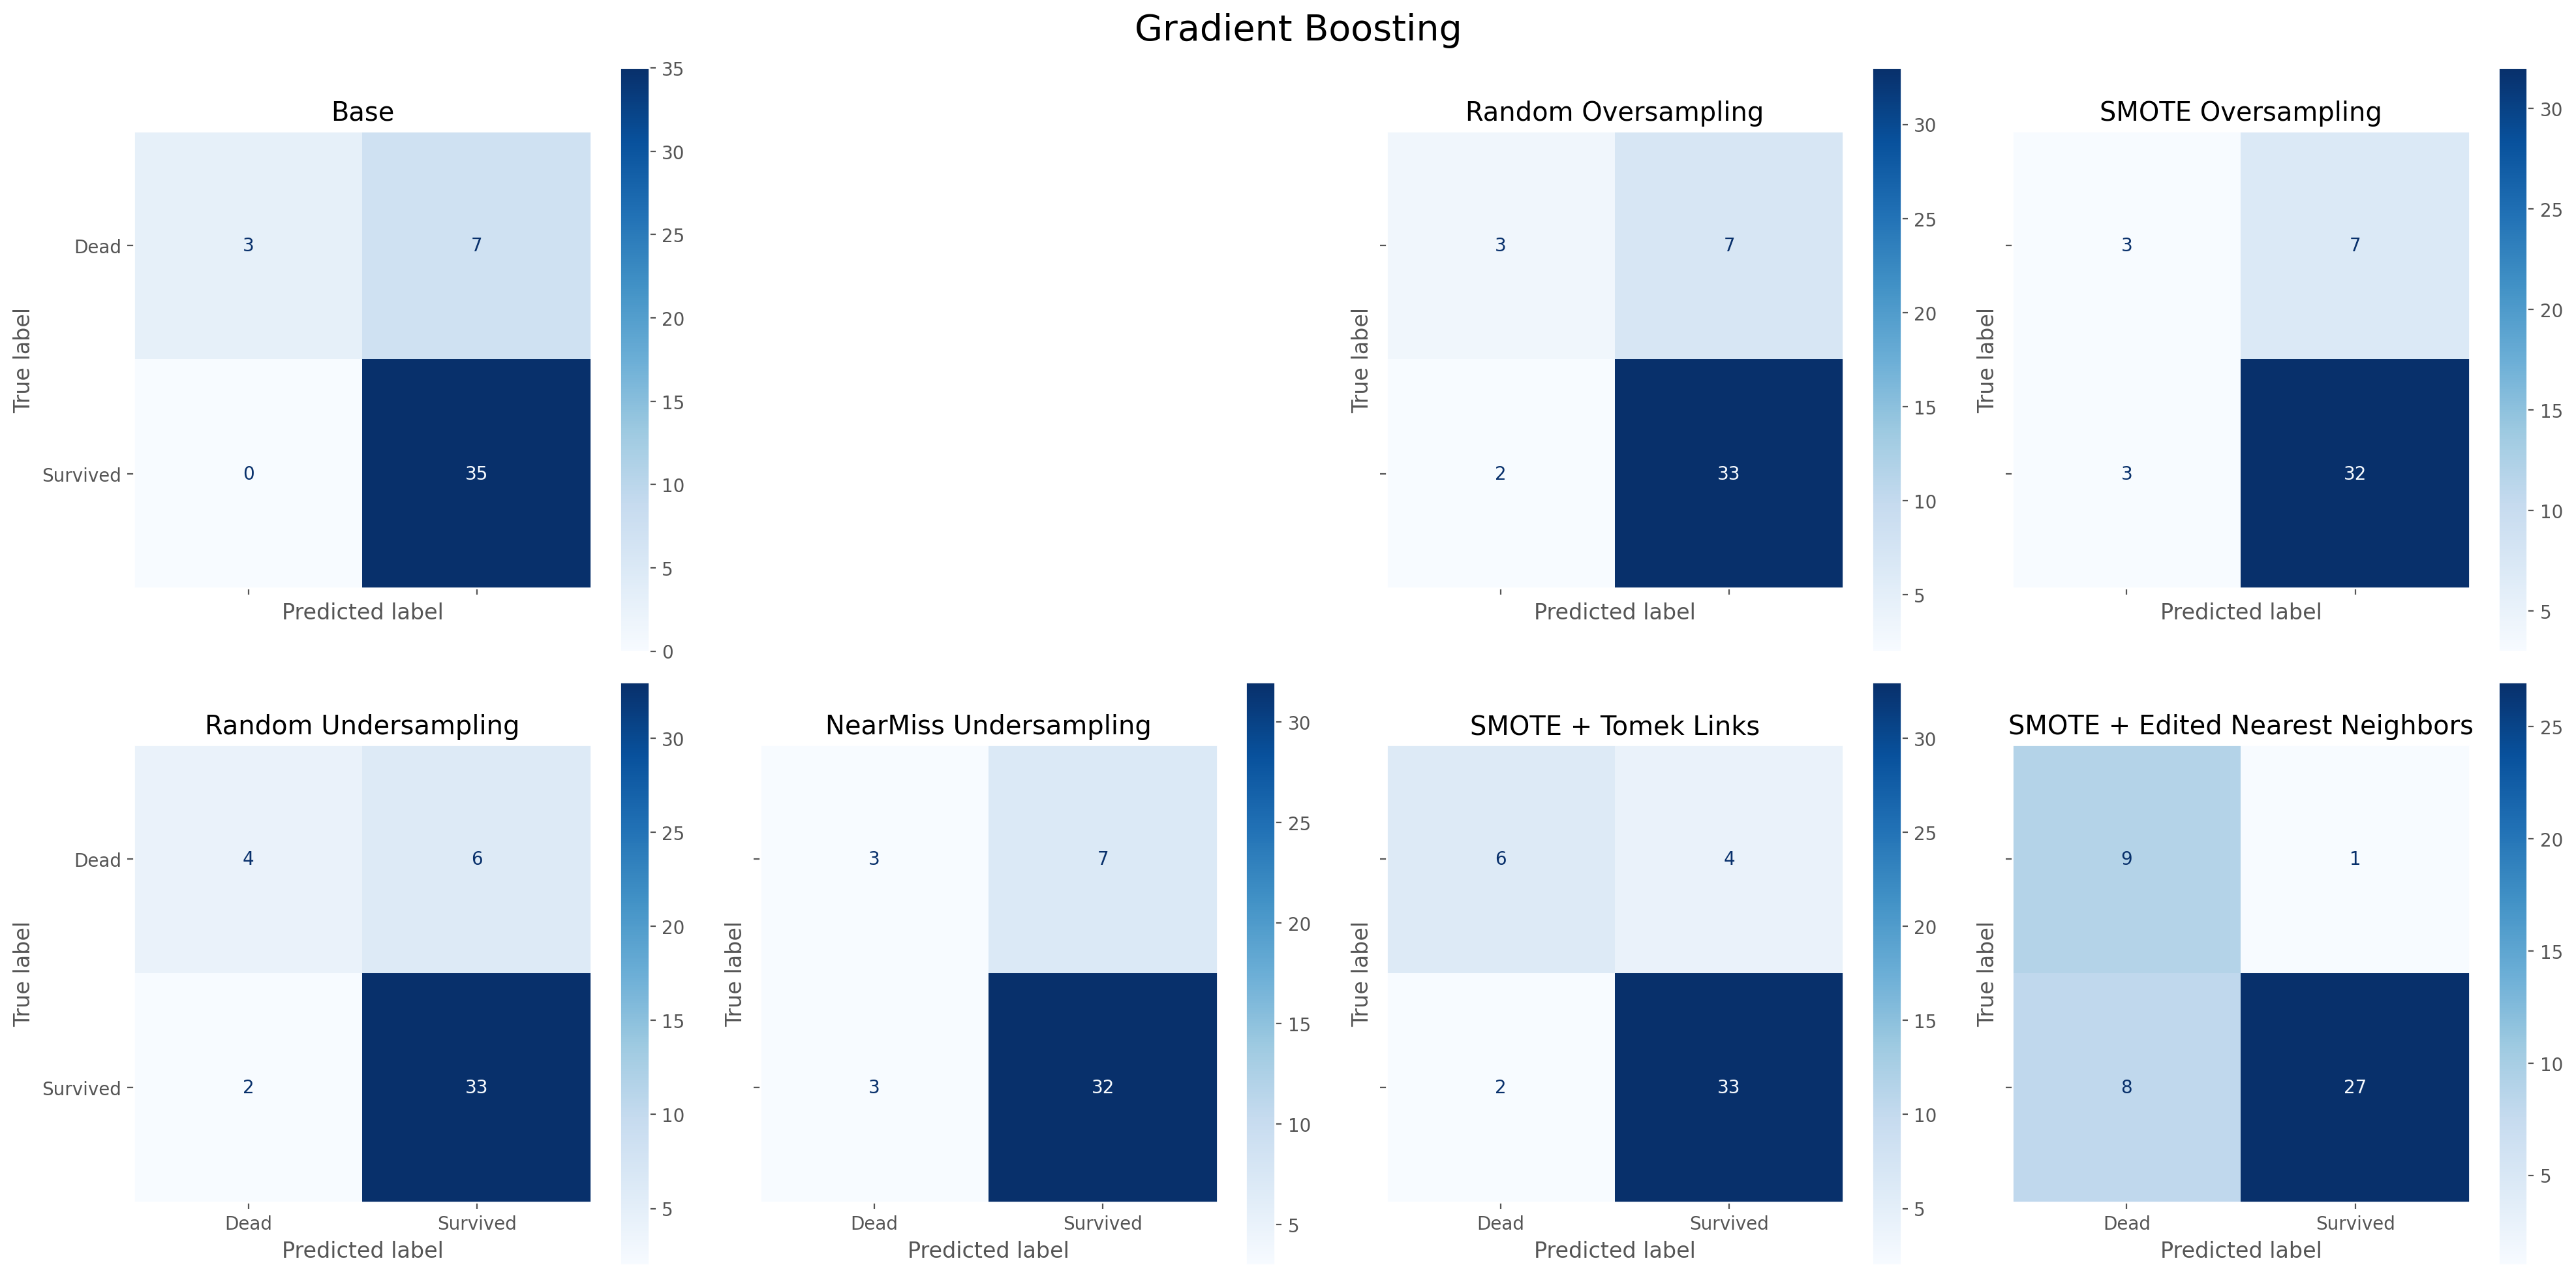

In [26]:
rf_preds = [rf_pred_base,rf_pred_base_balanced,rf_pred_ros,rf_pred_smote,rf_pred_rus,rf_pred_nearmiss,rf_pred_smotetomek,rf_pred_smoteenn]
rf_titles = [
    "Base",'Base (class_weight = "balanced")',"Random Oversampling","SMOTE Oversampling",
    "Random Undersampling","NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

gb_preds = [gb_pred_base,[""],gb_pred_ros,gb_pred_smote,gb_pred_rus,gb_pred_nearmiss,gb_pred_smotetomek,gb_pred_smoteenn]
gb_titles = [
    "Base","","Random Oversampling","SMOTE Oversampling",
    "Random Undersampling","NearMiss Undersampling","SMOTE + Tomek Links","SMOTE + Edited Nearest Neighbors"
]

for pred,title,suptitle in zip([rf_preds,gb_preds],[rf_titles,gb_titles],["Random Forest","Gradient Boosting"]):
    nrows,ncols = 2,4
    fig,ax = plt.subplots(nrows,ncols,figsize=(20,10),dpi=200,sharex=True,sharey=True)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            if len(pred[n]) == 1:
                pass
                n += 1
            else:
                ConfusionMatrixDisplay.from_predictions(y_test,pred[n],cmap="Blues",ax=ax[nrow,ncol])
                ax[nrow,ncol].set_title(title[n])
                ax[nrow,ncol].grid(False)
                n += 1

                if n == len(pred):
                    break

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.suptitle(suptitle,fontsize=20)
    plt.tight_layout()
    plt.show()

We can evaluate further by looking at the percentages of correct and incorrect predictions of every model. It's important to know that accuracy isn't always the best way to evaluate our models especially in an imbalanced dataset. It's advisable to use other metrics, such as precision, recall, and F1. On this graph, we'll focus at recall, which is the ratio between the numbers of positive samples correctly classified as positive to the total number of positive samples (the green bars). We can see that out of all resampling methods, the SMOTE + ENN method works the best on both Random Forest and Gradient Boosting models.

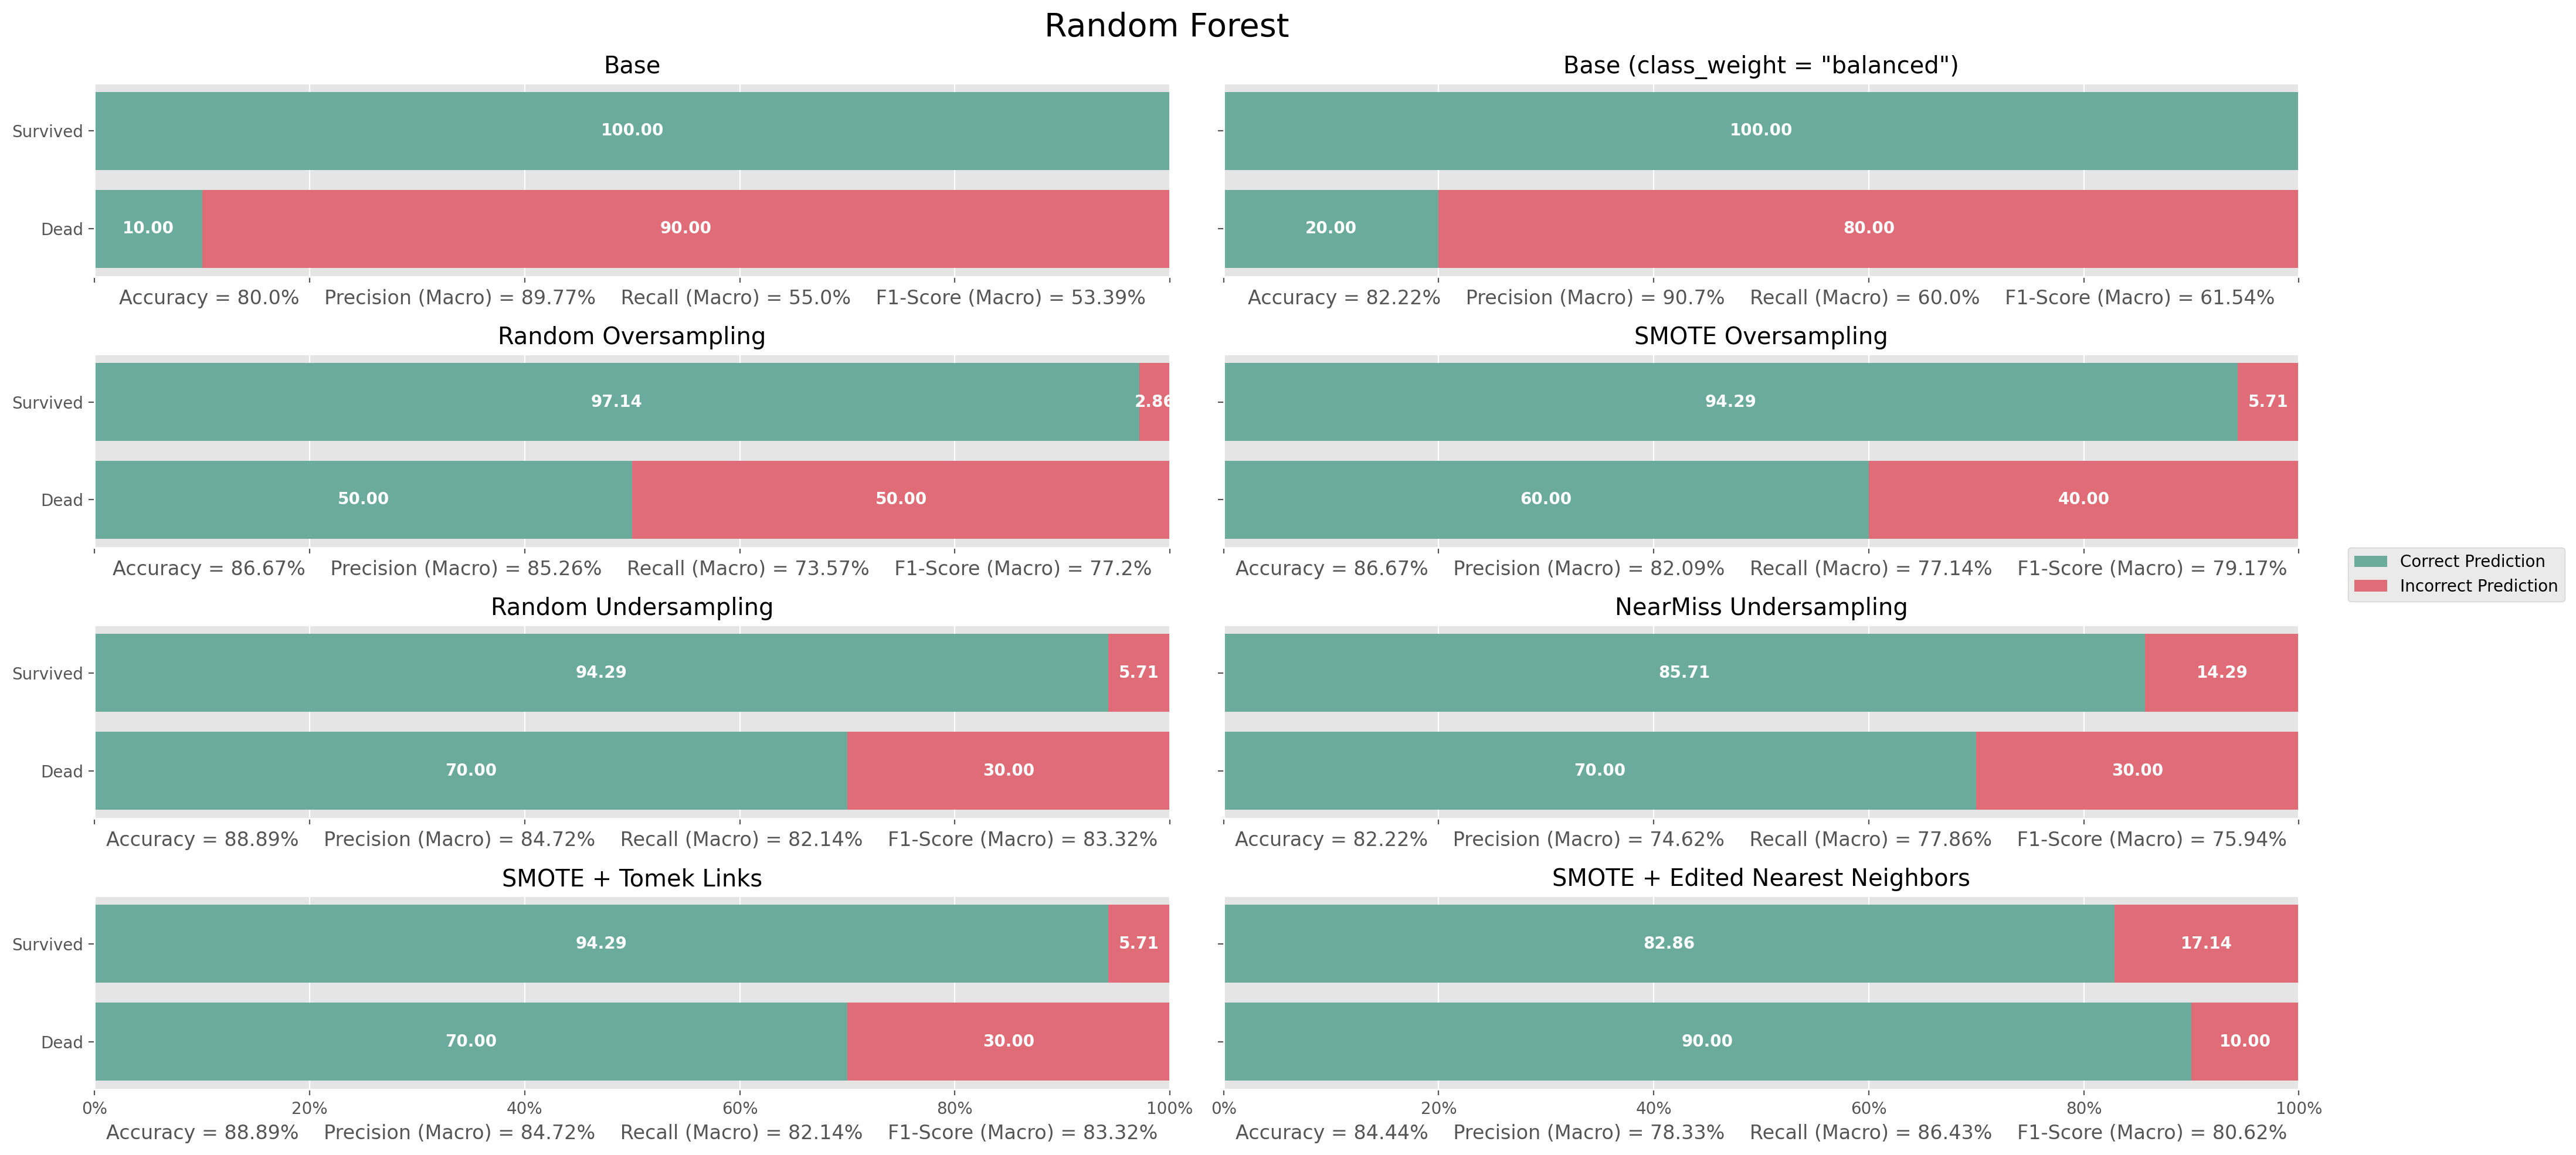

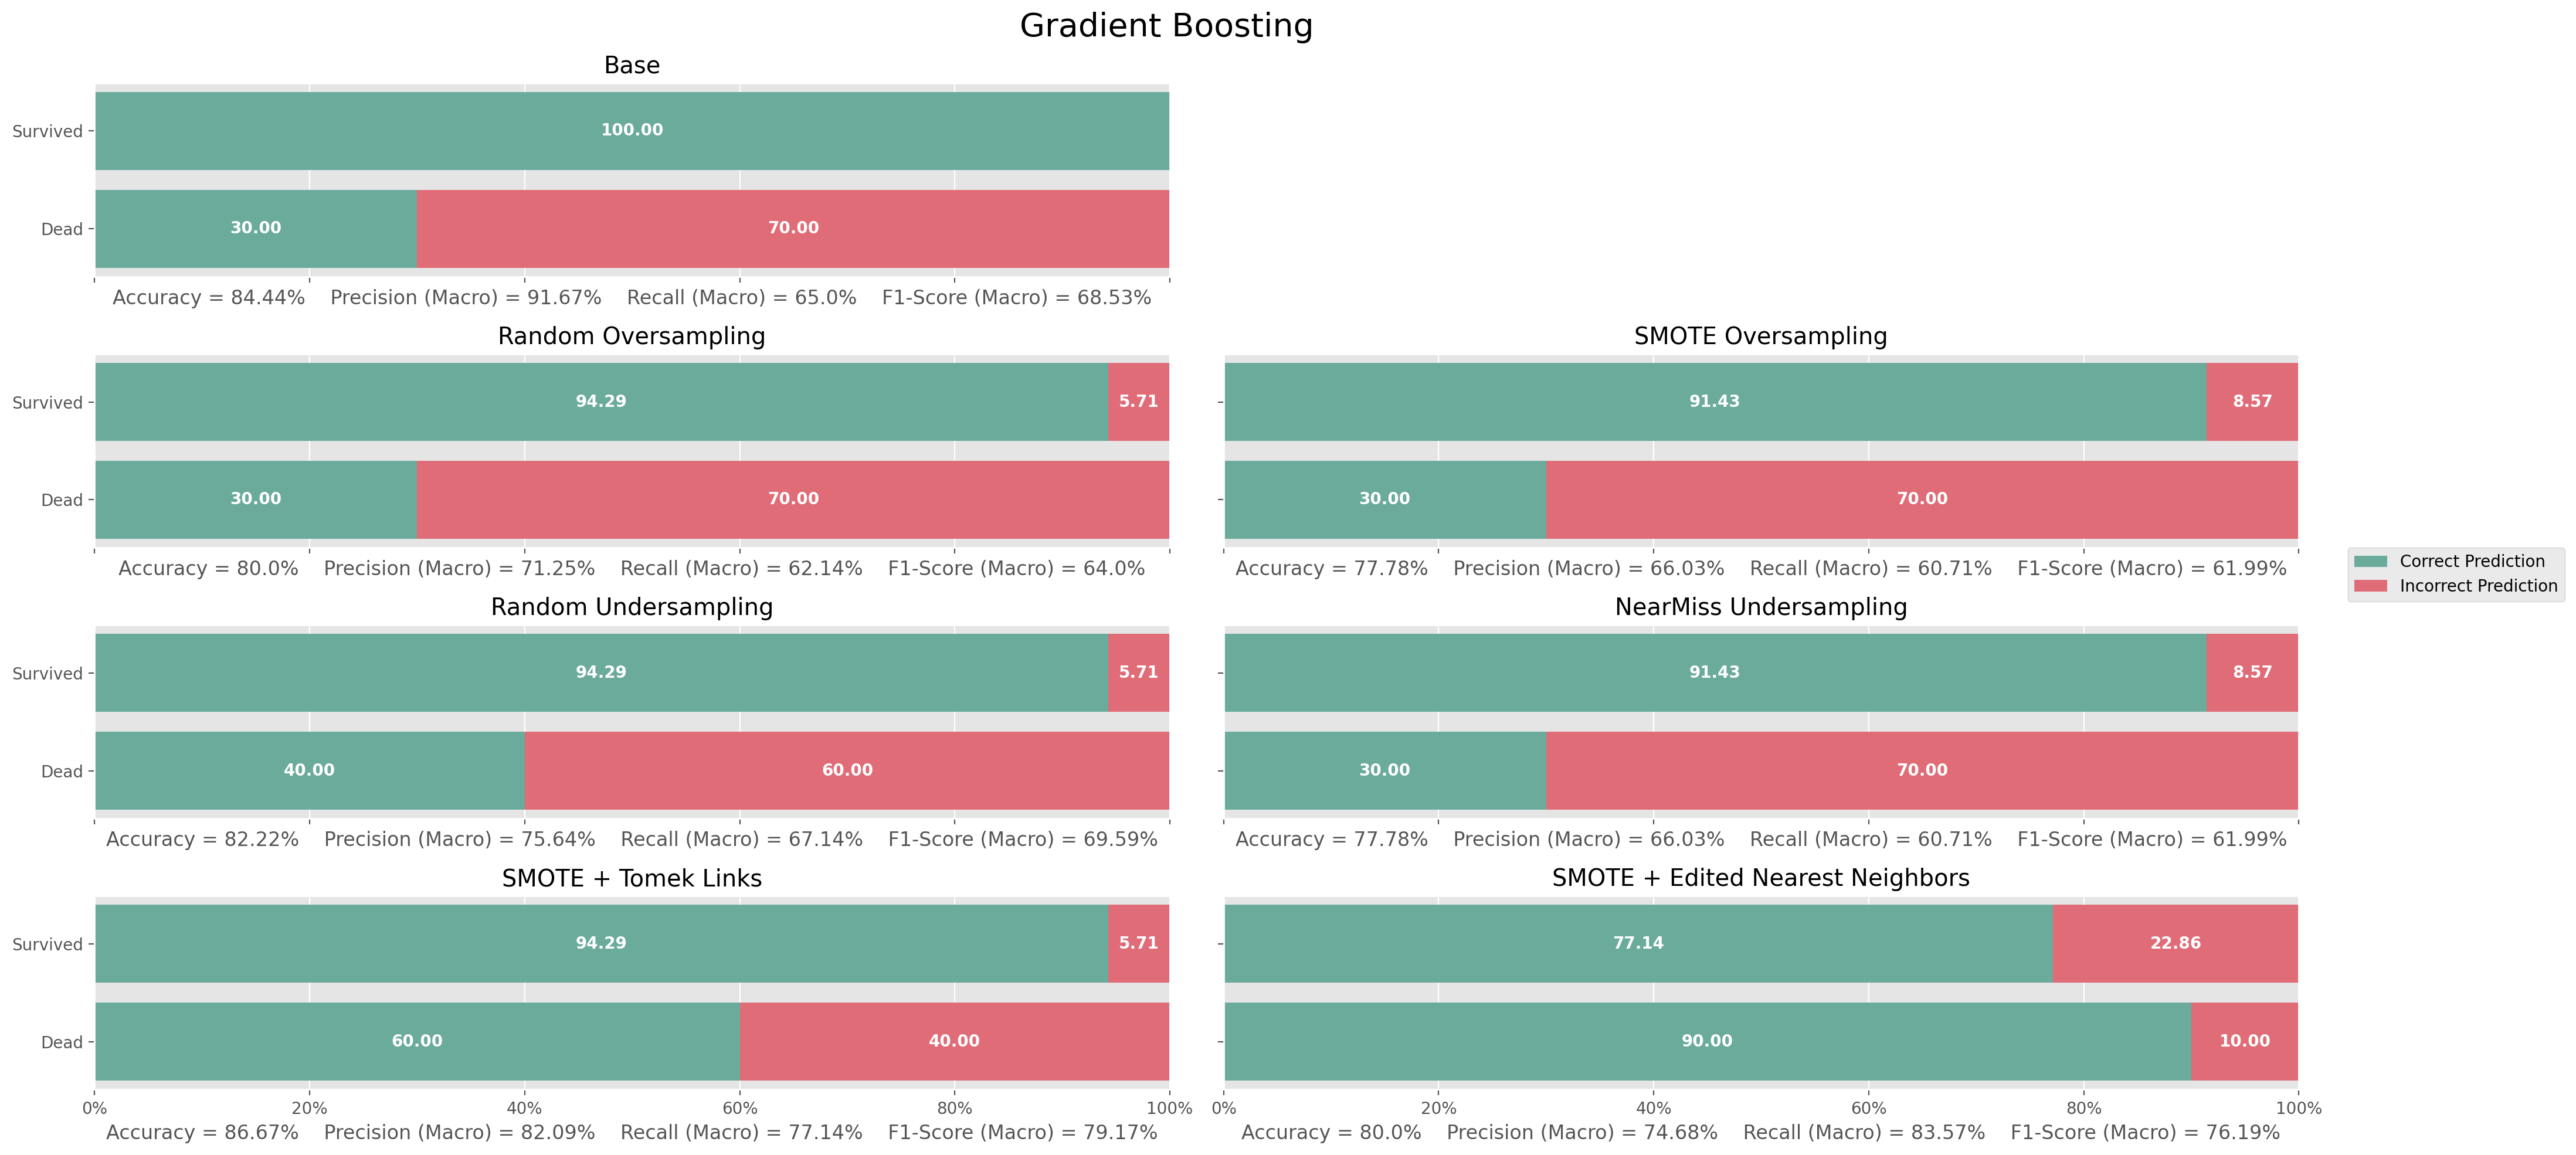

In [27]:
for pred,title,suptitle in zip([rf_preds,gb_preds],[rf_titles,gb_titles],["Random Forest","Gradient Boosting"]):
    nrows,ncols = 4,2
    fig,ax = plt.subplots(nrows,ncols,figsize=(20,10),dpi=200,sharex=True,sharey=True)

    n = 0
    for nrow in range(nrows):
        for ncol in range(ncols):
            if len(pred[n]) == 1:
                pass
                n += 1
            else:
                true_survived = recall_score(y_test,pred[n],pos_label="Survived") * 100
                false_survived = 100 - true_survived
                true_dead = recall_score(y_test,pred[n],pos_label="Dead") * 100
                false_dead = 100 - true_dead
                
                accuracy = accuracy_score(y_test,pred[n])
                precision = precision_score(y_test,pred[n],average="macro")
                recall = recall_score(y_test,pred[n],average="macro")
                f1 = f1_score(y_test,pred[n],average="macro")

                if true_dead == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")
                elif false_dead == 100:
                    ax[nrow,ncol].barh("Dead",false_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")
                elif true_survived == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                elif false_survived / (true_survived + false_survived) * 10 == 100:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",false_survived,color="#E06C78")
                else:
                    ax[nrow,ncol].barh("Dead",true_dead,color="#6AAB9C",label="Correct Prediction")
                    ax[nrow,ncol].barh("Dead",false_dead,left=true_dead,color="#E06C78",label="Incorrect Prediction")
                    ax[nrow,ncol].barh("Survived",true_survived,color="#6AAB9C")
                    ax[nrow,ncol].barh("Survived",false_survived,left=true_survived,color="#E06C78")

                ax[nrow,ncol].set_title(title[n])
                ax[nrow,ncol].set_xlim(xmax=100)
                ax[nrow,ncol].set_xlabel(
                    f"Accuracy = {round(accuracy * 100,2)}%    Precision (Macro) = {round(precision * 100,2)}%    Recall (Macro) = {round(recall * 100,2)}%    F1-Score (Macro) = {round(f1 * 100,2)}%"
                )

                for container in ax[nrow,ncol].containers:
                    ax[nrow,ncol].bar_label(container,fmt="%.2f",label_type="center",color="white",fontweight="bold")

                n += 1

    ax[nrow,ncol].set_xticks(np.arange(0,101,20),[f"{xtick}%" for xtick in np.arange(0,101,20)])
    handles,labels = ax[nrow,ncol].get_legend_handles_labels()
    fig.legend(handles,labels,bbox_to_anchor=(1,0.5),loc="center left")

    for ax in ax.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

    plt.suptitle(suptitle,fontsize=20)
    plt.tight_layout()
    plt.show()

Show the prediction results of the Random Forest and Gradient Boosting models with SMOTE + ENN method.

In [28]:
pd.DataFrame({
    "probability_survived":rf_proba_smoteenn[:,1] * 100,
    "probability_dead":rf_proba_smoteenn[:,0] * 100,
    "prediction":rf_pred_smoteenn,
    "actual":y_test,
    "conclusion":[True if i == j else False for i,j in zip(y_test,rf_pred_smoteenn)]
}).reset_index(drop=True).head(10)

,probability_survived,probability_dead,prediction,actual,conclusion
0,66.0,34.0,Survived,Survived,True
1,87.0,13.0,Survived,Survived,True
2,61.0,39.0,Survived,Survived,True
3,30.0,70.0,Dead,Dead,True
4,43.0,57.0,Dead,Dead,True
5,82.0,18.0,Survived,Survived,True
6,85.0,15.0,Survived,Survived,True
7,41.0,59.0,Dead,Survived,False
8,8.0,92.0,Dead,Dead,True
9,29.0,71.0,Dead,Survived,False


In [36]:
pd.DataFrame({
    "probability_survived":gb_proba_smoteenn[:,1] * 100,
    "probability_dead":gb_proba_smoteenn[:,0] * 100,
    "prediction":gb_pred_smoteenn,
    "actual":y_test,
    "conclusion":[True if i == j else False for i,j in zip(y_test,gb_pred_smoteenn)]
}).reset_index(drop=True).head(10)

,probability_survived,probability_dead,prediction,actual,conclusion
0,2.333505,97.666495,Dead,Survived,False
1,99.982383,0.017617,Survived,Survived,True
2,84.785228,15.214772,Survived,Survived,True
3,2.806210,97.193790,Dead,Dead,True
4,3.903181,96.096819,Dead,Dead,True
5,99.990174,0.009826,Survived,Survived,True
6,99.897687,0.102313,Survived,Survived,True
7,54.050504,45.949496,Survived,Survived,True
8,0.006271,99.993729,Dead,Dead,True
9,0.657082,99.342918,Dead,Survived,False


# Final Models

Since we know that SMOTE + ENN is the best resampling method for this dataset, we'll use it to resample the whole dataset.

In [30]:
smoteenn = SMOTEENN(random_state=random_state)
X_smoteenn,y_smoteenn = smoteenn.fit_resample(X,y)

Create the final models by training them with the whole dataset that has been resampled.

In [31]:
# Random Forest
final_rf_model = RandomForestClassifier(random_state=random_state)
final_rf_model.fit(X_smoteenn,y_smoteenn)

# Gradient Boosting
final_gb_model = GradientBoostingClassifier(random_state=random_state)
final_gb_model.fit(X_smoteenn,y_smoteenn)

GradientBoostingClassifier(random_state=62)

Save the final models for future use.

In [32]:
models = [final_rf_model,final_gb_model]
names = ["random_forest_smote_enn_model","gradient_boosting_smote_enn_model"]
extension = "json"

for model,name in zip(models,names):
    with open(f"{name}.{extension}","wb") as files:
        dump(model,files)
    print(f"{name}.{extension} has been downloaded")

random_forest_smote_enn_model.json has been downloaded
gradient_boosting_smote_enn_model.json has been downloaded


# Conclusion

In conclusion, it can be seen that the SMOTE + ENN method balances the dataset really well and increases the performance of our models. The Random Forest model's predictions for *Survival* and *Dead* classes respectively are 82.86% and 90% correct while the Gradient Boosting model's are 77.14% and 90%. Since the Random Forest model has a slightly better performance than the Gradient Boosting model, it's advisable to use the former. This project shows that ensemble methods in machine learning can be used effectively for binary classification of electronic health records of patients with cardiovascular heart diseases.